# Modeling dynamics

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from mgsa.io import get_function, samples_from_soils
from mgsa.helpers import plot

In [57]:
def timestep(rhs, y_n, params, dt):
    """RK4 timestep
    
    Args:
        rhs (callable): Right hand side derivative function dy/dt. Should return
            an array of length d.
        y_n (np.ndarray[float]): Current state. Length d.
        params (list): variable length list of parameters.
        dt (float): stepsize.
    
    Returns:
        (np.ndarray) array of length d, the updated state, using RK4.
    """
    k_1 = rhs(y_n, params)
    k_2 = rhs(y_n + dt*k_1/2, params)
    k_3 = rhs(y_n + dt*k_2/2, params)
    k_4 = rhs(y_n + dt*k_3, params)
    y_new = y_n + (dt/6) * (k_1 + 2*k_2 + 2*k_3 + k_4)
    return y_new


def simulate(rhs, y0, params, dt, T):
    """Simulate an ODE from an initial condition over a specified interval.
    
    Args:
        rhs (callable): Right hand side derivative function dy/dt. Should return
            an array of length d.
        y0 (np.ndarray[float]): Initial condition. Length d.
        params (list): variable length list of parameters.
        dt (float): stepsize.
        T (float): final time.
    
    Returns:
        (np.ndarray) Array of shape (d, N). The state history over the interval.
    """
    N = int(T/dt)
    d = len(y0)
    ys = np.zeros([d, N])
    ys[:,0] = y0
    y = ys[:,0]
    for i in range(N-1):
        y_new = timestep(rhs, y, params, dt)
        ys[:, i + 1] = y_new
        y = y_new
    return ys

Goal: simulate consumer resource model and find parameter values


\begin{align*}
    \dot{x} &=  \bigg[\gamma_A r_A \frac{A}{K_A + A} + \gamma_I r_I \frac{I}{K_I + I} \bigg] \frac{\tilde{C}}{K_C + \tilde{C}}x - \mu x\\
    \dot{A} &= -r_A \frac{A}{K_A + A} x\\
    \dot{I} &= \bigg[r_A \frac{A}{K_A + A} - r_I \frac{I}{K_I + I} \bigg]x\\
    \dot{\tilde{C}} &= - \frac{\tilde{C}}{K_C + \tilde{C}} x
\end{align*}

Here, $\tilde{C} = C/r_c$ is the normalized amount of limiting nutrient. Here, we then wish to fit rate and uptake parameters ($r$ and $\gamma$) as well as the initial biomass $x(0)$. We will use a sensitivity analysis to select $C(0)$ as well as each affinity, $K$.

In [3]:
def RHS(y, params):
    x, A, I, C = y
    gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu = params

    dx = (gamma_A*r_A*A/(K_A + A) + gamma_I*r_I*I/(K_I + I))*x*C/(K_C + C) - mu*x
    dA = -r_A*x*A/(K_A + A)
    dI = (r_A*A/(K_A + A) - r_I*I/(K_I + I))*x
    dC = - x*C/(K_C + C)
    
    dydt = np.array([dx, dA, dI, dC])
    return dydt


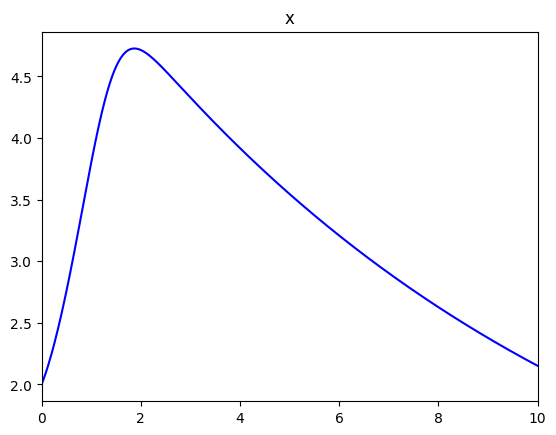

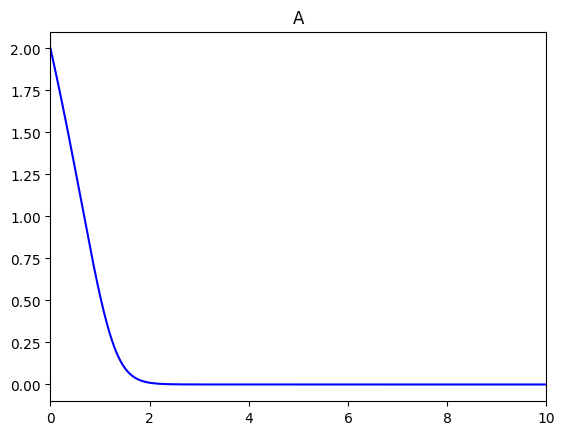

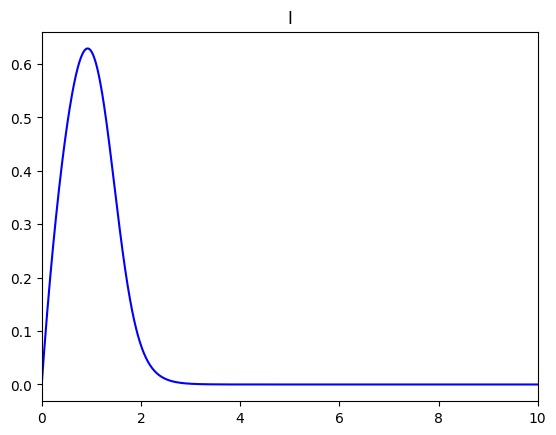

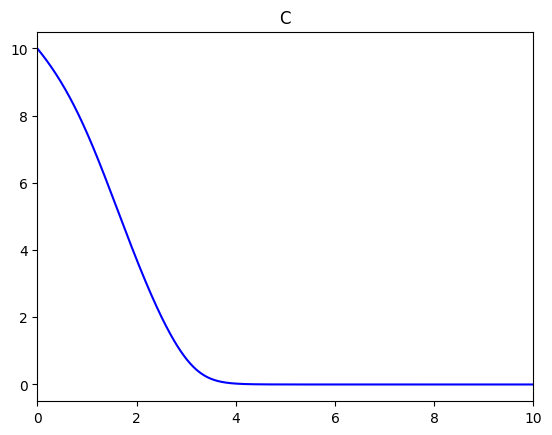

In [4]:
dt = 0.01
T = 10
x_0 = 2
A_0 = 2
I_0 = 0
C_0 = 10
gamma_A = 1
gamma_I = 1
r_A = 1
r_I = 1
K_A = K_I = K_C = 1
mu = 0.1

y0 = np.array([x_0, A_0, I_0, C_0])
params = [gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu]
x, A, I, C = simulate(RHS, y0, params, dt, T)
t = np.linspace(0, T, int(T/dt))

plt.plot(t, x, color = 'blue')
plt.xlim(0,T)
plt.title('x')
plt.show()
plt.plot(t, A, color = 'blue')
plt.xlim(0,T)
plt.title('A')
plt.show()
plt.plot(t, I, color = 'blue')
plt.xlim(0,T)
plt.title('I')
plt.show()
plt.plot(t, C, color = 'blue')
plt.xlim(0,T)
plt.title('C')
plt.show()

Run a curvefit.

Optimized parameters:
gamma_A = 0.9657
gamma_I = 0.0001
r_A = 0.4960
r_I = 16.6275


(0.0, 9.0)

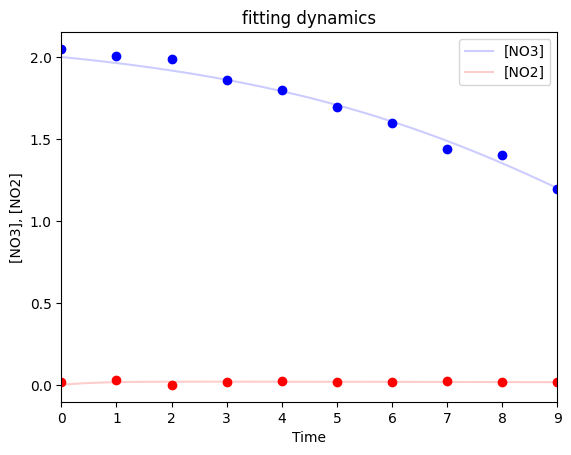

In [5]:
native = 5 #which native soil (0 through 9)
pert = 3 #which perturbed soil (0 through 10)
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17']
sample = samples_from_soils(soils[native])[pert]


t_data = np.linspace(0,19,20)
function = get_function(sample)

A_data = np.zeros(10)
I_data = np.zeros(10)
for i in range(3):
    A_data += function[i]
    I_data += function[i + 3]
    
A_data = A_data/3
I_data = I_data/3

y_data = np.concatenate([A_data, I_data])

x_0 = 0.1
A_0 = 2
I_0 = 0
C_0 = 3
K_A = K_I = K_C = 1
mu = 0.01 
dt = 0.05
T = 9
N = int(T/dt)

def model(t, gamma_A, gamma_I, r_A, r_I):
    
    indices = np.linspace(0,int(9/dt-1),10).astype(int)

    y0 = np.array([x_0, A_0, I_0, C_0])
    params = [gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu]
    
    _, A, I, _ = simulate(RHS, y0, params, dt, T)
    A_out = A[indices]
    I_out = I[indices]
    
    return np.concatenate([A_out, I_out])

initial_guess = [1.0, 1.0, 0.1, 0.1] 


bounds = ([0.0001, 0.0001, 0.0001, 0.0001], [100, 100, 100, 100])


popt, pcov = curve_fit(model, t_data, y_data, 
                        p0=initial_guess, 
                        bounds=bounds,
                        maxfev=100000)  

print("Optimized parameters:")
print(f"gamma_A = {popt[0]:.4f}")
print(f"gamma_I = {popt[1]:.4f}")
print(f"r_A = {popt[2]:.4f}")
print(f"r_I = {popt[3]:.4f}")

y0 = np.array([x_0, A_0, I_0, C_0])
params = [popt[0], popt[1], popt[2], popt[3], K_A, K_I, K_C, mu]
x, A, I, C = simulate(RHS, y0, params, dt, T)

t = np.linspace(0,9,N)
t_scatter = np.linspace(0,9,10)


plt.plot(t, A, color = 'Blue', alpha = 0.2, label = '[NO3]')
plt.plot(t, I, color = 'Red', alpha = 0.2, label = '[NO2]')
plt.title('fitting dynamics')
plt.scatter(t_scatter, A_data, color = 'Blue')
plt.scatter(t_scatter, I_data, color = 'Red')
plt.xlabel('Time')
plt.legend()
plt.ylabel('[NO3], [NO2]')
plt.xlim(0,9)

# Repeat but for CHL +

# Now with both drug and no drug

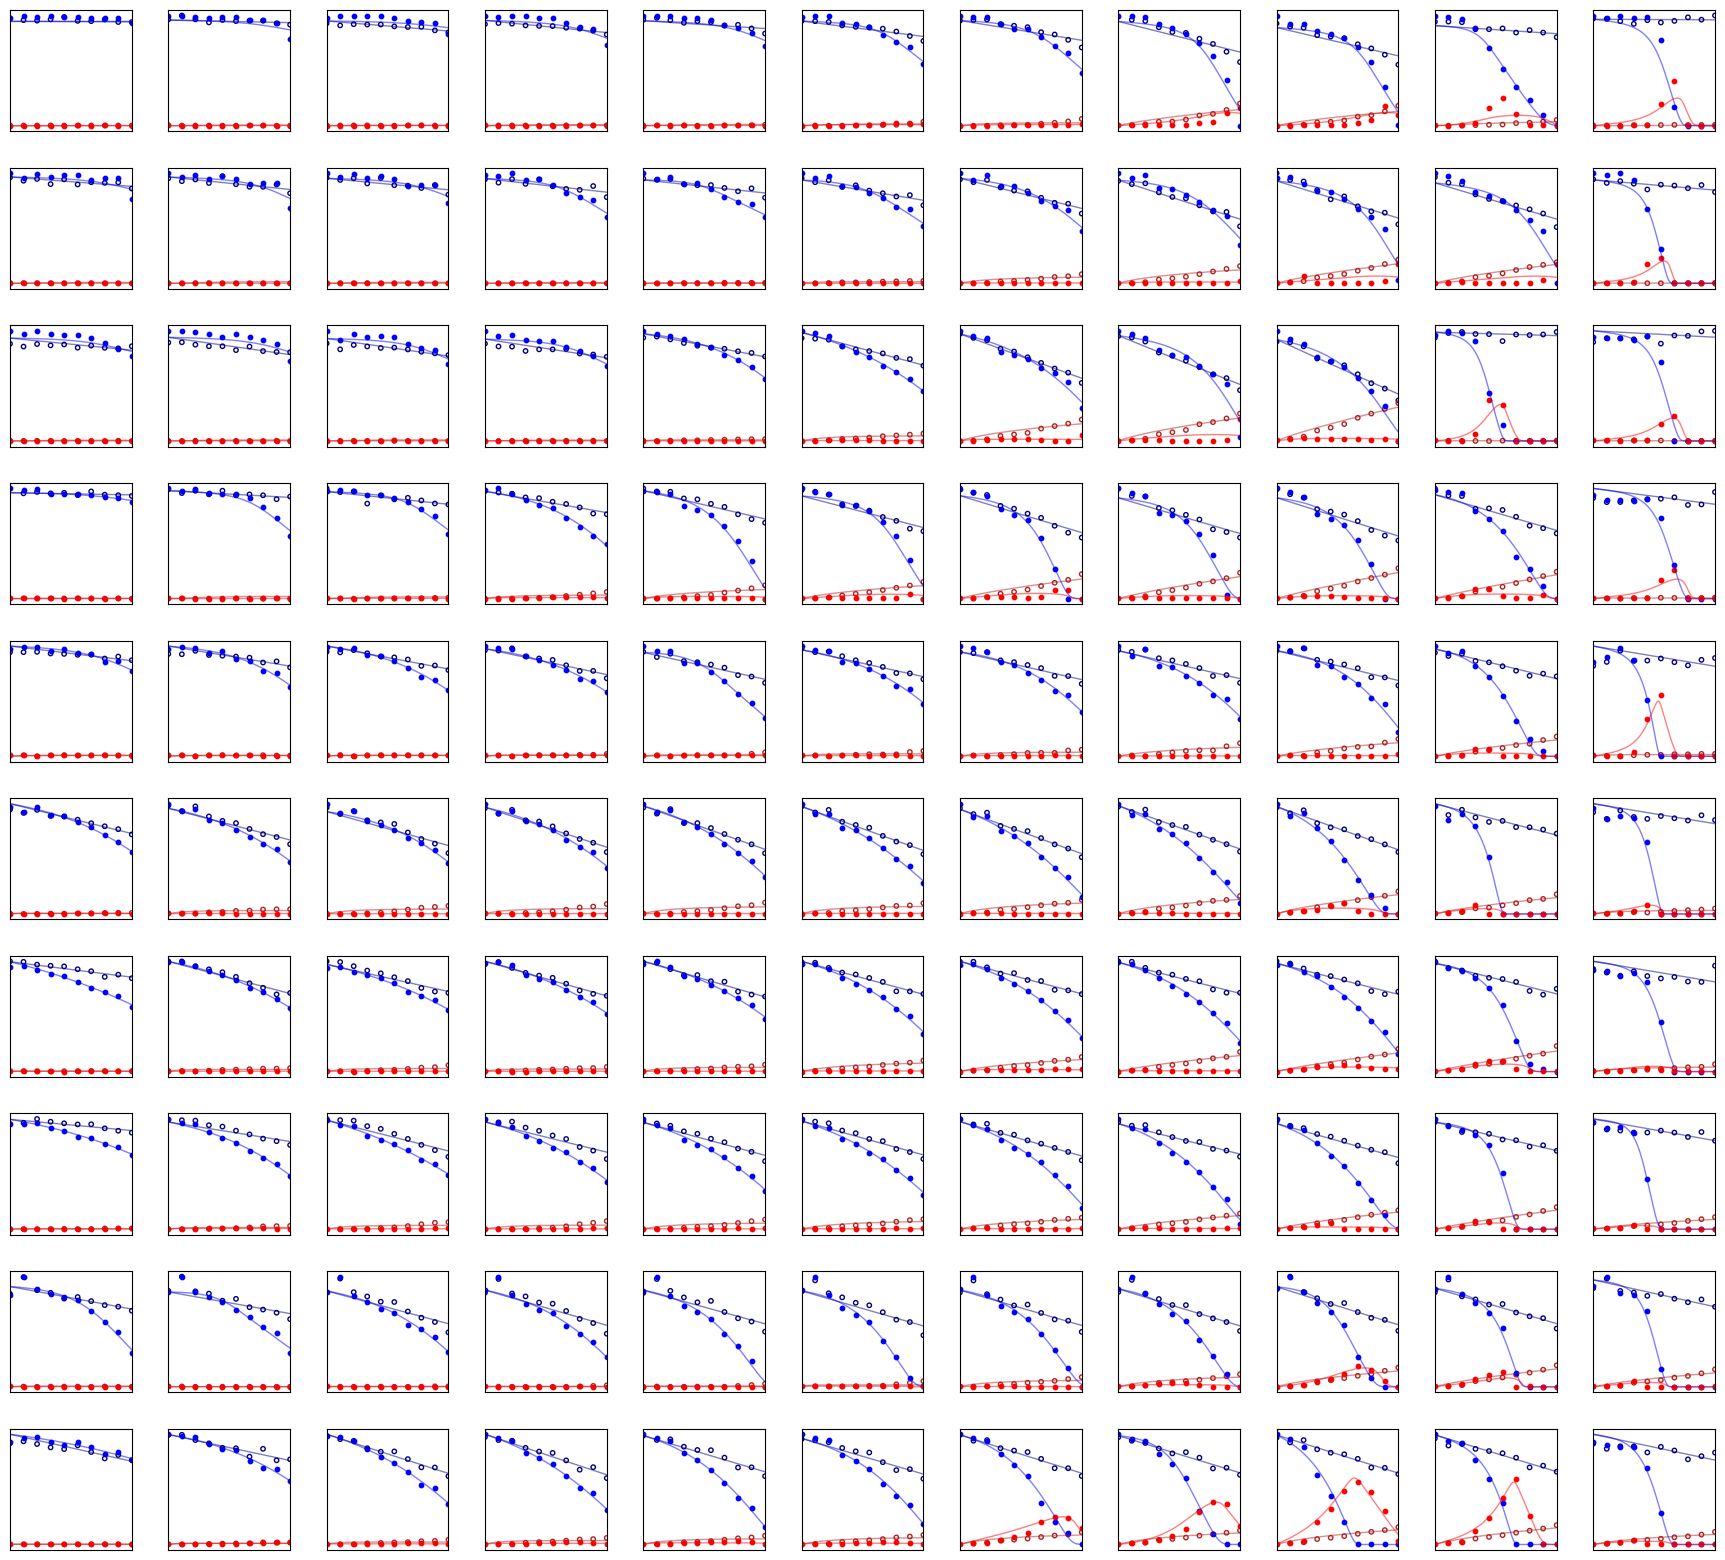

In [6]:

fig, axs = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)


t_data = np.linspace(0, 19, 20)
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 
         'Soil15', 'Soil16', 'Soil17']

x_0 = 0.1
A_0 = 2
I_0 = 0
C_0 = 2
K_A = 0.1
K_I = 0.1
K_C = 1
mu = 0
dt = 0.05
T = 9
N = int(T/dt)

param_values = np.zeros((10,11,6))

for native in range(10): 
    for pert in range(11):  

        sample = samples_from_soils(soils[9 - native])[pert]
        
        function = get_function(sample, drug = 'CHL')
        A_data_drug = np.zeros(10)
        I_data_drug = np.zeros(10)
        for i in range(3):
            A_data_drug += function[i]
            I_data_drug += function[i + 3]
        A_data_drug = A_data_drug/3
        I_data_drug = I_data_drug/3
        y_data_drug = np.concatenate([A_data_drug, I_data_drug])
        
        function = get_function(sample)
        A_data = np.zeros(10)
        I_data = np.zeros(10)
        for i in range(3):
            A_data += function[i]
            I_data += function[i + 3]
        A_data = A_data/3
        I_data = I_data/3
        y_data = np.concatenate([A_data, I_data])
        
        def model_drug(t, r_A, r_I):
            indices = np.linspace(0, int(9/dt-1), 10).astype(int)

            y0 = np.array([x_0, A_0, I_0, C_0])
            params = [0, 0, r_A, r_I, K_A, K_I, K_C, mu]
            _, A, I, _ = simulate(RHS, y0, params, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        
        initial_guess = [1.0, 1.0]
        bounds = ([0.01, 0.01,], [10, 10])
        
        popt, pcov = curve_fit(model_drug, t_data, y_data_drug, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=100000)
        
        param_values[native, pert][0] = popt[0]
        param_values[native, pert][1] = popt[1]

        y0 = np.array([x_0, A_0, I_0, C_0])
        params = [0, 0, popt[0], popt[1],  K_A, K_I, K_C, mu]
        x, A, I, C = simulate(RHS, y0, params, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='navy', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='firebrick', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data_drug, color='navy', s=10, facecolors = 'none')
        ax.scatter(t_scatter, I_data_drug, color='firebrick', s=10, facecolors = 'none')
        
        def model(t, gamma_A, gamma_I, r_A, r_I):
            indices = np.linspace(0, int(9/dt-1), 10).astype(int)

            y0 = np.array([x_0, A_0, I_0, C_0])
            params = [gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu]
            _, A, I, _ = simulate(RHS, y0, params, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        initial_guess = [1.0, 1.0, 0.1, 0.1]
        bounds = ([0.001, 0.001, 0.001, 0.001], [10, 10, 10, 10])
        
        popt, pcov = curve_fit(model, t_data, y_data, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=100000)
        
        param_values[native, pert][2] = popt[0]
        param_values[native, pert][3] = popt[1]
        param_values[native, pert][4] = popt[2]
        param_values[native, pert][5] = popt[3]
        

        y0 = np.array([x_0, A_0, I_0, C_0])
        params = [popt[0], popt[1], popt[2], popt[3], K_A, K_I, K_C, mu]
        x, A, I, C = simulate(RHS, y0, params, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='Blue', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='Red', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data, color='Blue', s=10)
        ax.scatter(t_scatter, I_data, color='Red', s=10)
        
        ax.set_xlim(0, 9)
        
        ax.set_xticks([])
        ax.set_yticks([])
        

plt.show()

# Need to constrain global parameters

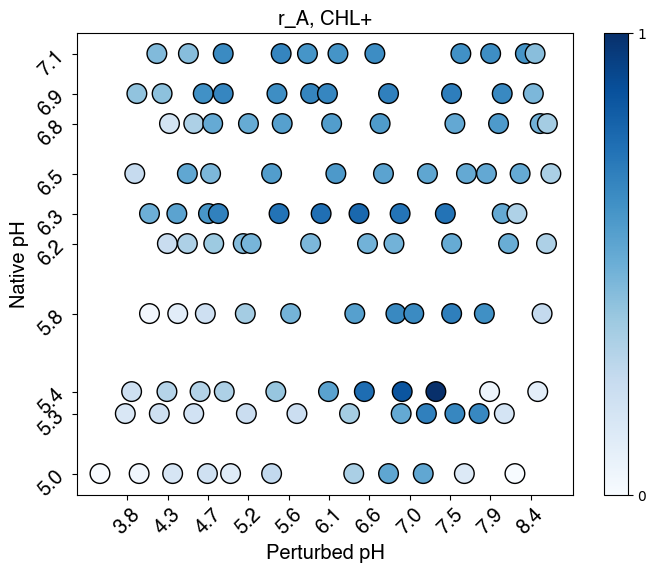

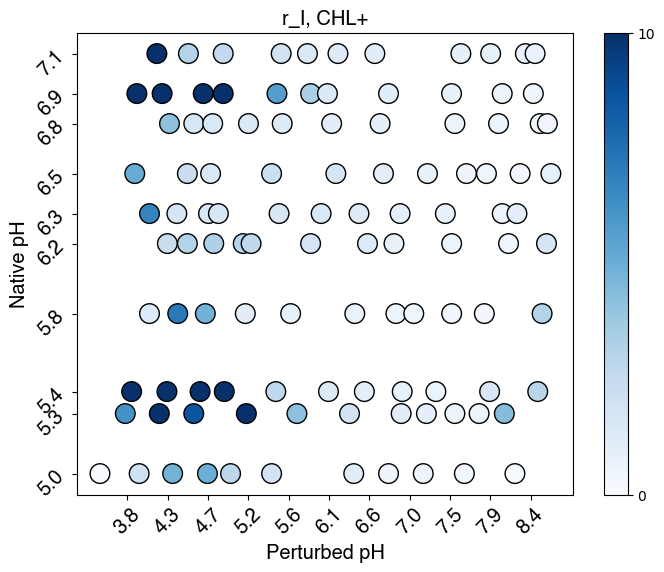

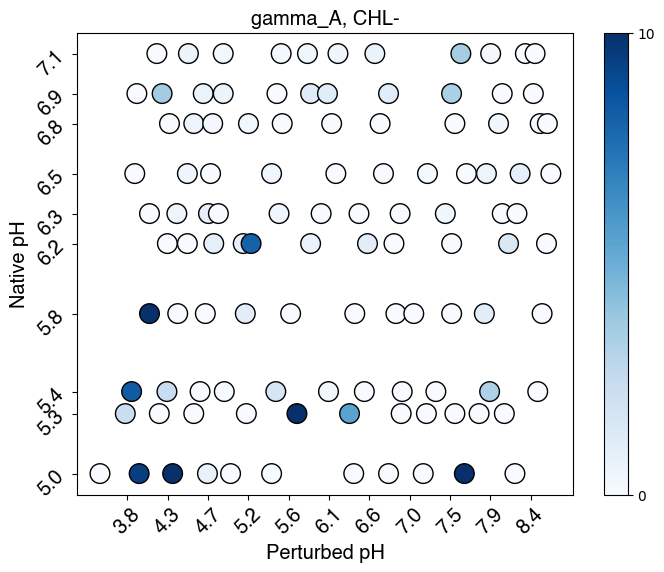

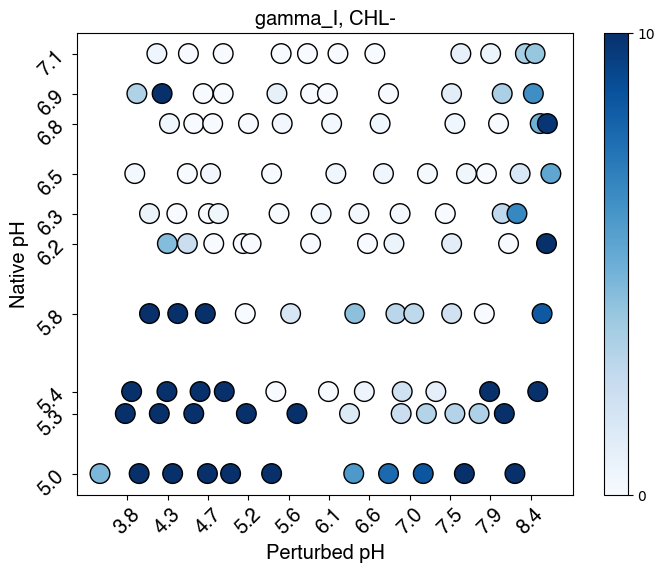

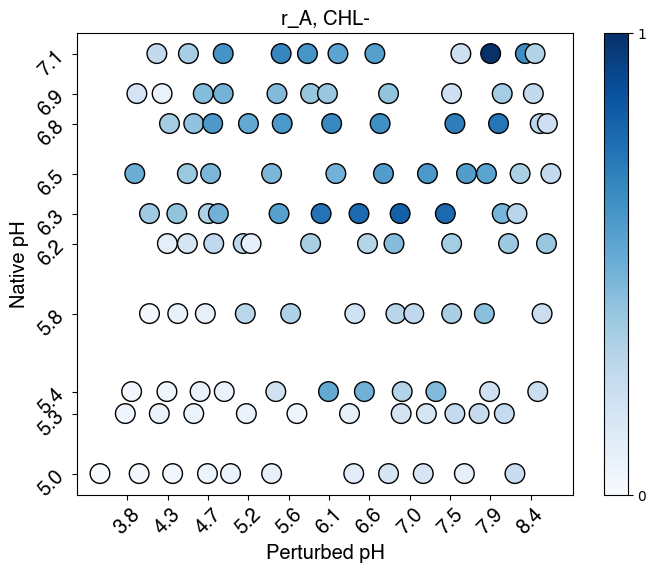

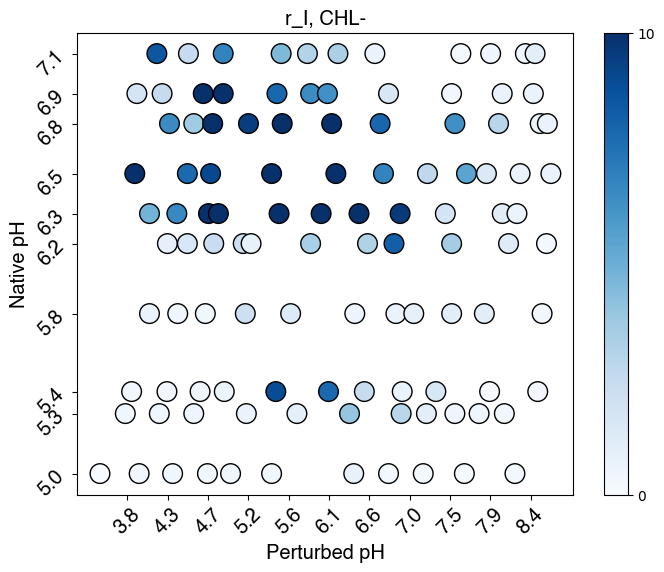

(8, 10):  [6.29448425e-01 3.26328093e-01 1.00000000e-03 4.92005729e+00
 3.62490673e-01 6.19399745e-01]
(7,  7):  [0.69640813 0.76698448 0.17119146 0.18727656 0.76563554 2.72511645]
(2,  2):  [2.75589044e-01 1.00000000e+01 1.00149118e-03 9.99999955e+00
 8.81549656e-02 3.66157921e-01]


In [ ]:
plot(param_values[:,:,0], 'r_A, CHL+')
plot(param_values[:,:,1], 'r_I, CHL+')
plot(param_values[:,:,2], 'gamma_A, CHL-')
plot(param_values[:,:,3], 'gamma_I, CHL-')
plot(param_values[:,:,4], 'r_A, CHL-')
plot(param_values[:,:,5], 'r_I, CHL-')

print('(8, 10): ', param_values[7,9,:])
print('(7,  7): ', param_values[6,6,:])
print('(2,  2): ', param_values[1,1,:])

param_1 = param_values[1,1,:]
param_2 = param_values[6,6,:]
param_3 = param_values[7,9,:]

Fit global parameters using three representative samples (8, 10), (7, 7), (2, 2)

C_0 9.523568775722886
K_A 1.8899952722635058
K_I 0.046204099045724374
K_C 0.09448473326028811
x_0 0.2768430062827733


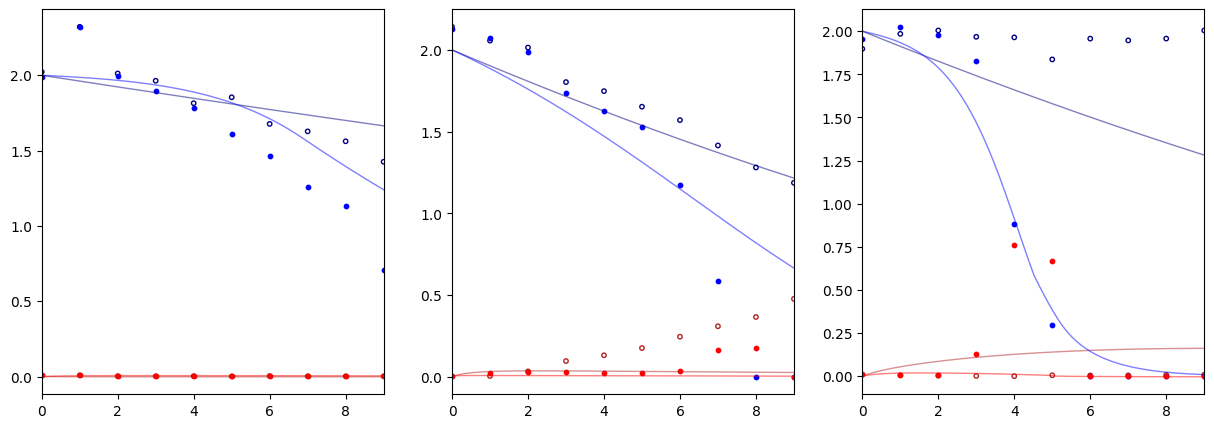

In [8]:
t_data = np.linspace(0, 19, 20)
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 
         'Soil15', 'Soil16', 'Soil17']

#x_0 = 1
mu = 0
A_0 = 2
I_0 = 0

dt = 0.05
T = 9
N = int(T/dt)

t = np.linspace(0, T, int(T/dt))

## first gather data for 3 cases 

native = 1
pert = 1

sample = samples_from_soils(soils[native])[pert]
        
function = get_function(sample, drug = 'CHL')
A_data_drug = np.zeros(10)
I_data_drug = np.zeros(10)
for i in range(3):
    A_data_drug += function[i]
    I_data_drug += function[i + 3]
A_data_drug_1 = A_data_drug/3
I_data_drug_1 = I_data_drug/3
y_data_drug_1 = np.concatenate([A_data_drug_1, I_data_drug_1])

function = get_function(sample)
A_data = np.zeros(10)
I_data = np.zeros(10)
for i in range(3):
    A_data += function[i]
    I_data += function[i + 3]
A_data_1 = A_data/3
I_data_1 = I_data/3
y_data_1 = np.concatenate([A_data_1, I_data_1])

native = 6
pert = 6

sample = samples_from_soils(soils[native])[pert]
        
function = get_function(sample, drug = 'CHL')
A_data_drug = np.zeros(10)
I_data_drug = np.zeros(10)
for i in range(3):
    A_data_drug += function[i]
    I_data_drug += function[i + 3]
A_data_drug_2 = A_data_drug/3
I_data_drug_2 = I_data_drug/3
y_data_drug_2 = np.concatenate([A_data_drug_2, I_data_drug_2])

function = get_function(sample)
A_data = np.zeros(10)
I_data = np.zeros(10)
for i in range(3):
    A_data += function[i]
    I_data += function[i + 3]
A_data_2 = A_data/3
I_data_2 = I_data/3
y_data_2 = np.concatenate([A_data_2, I_data_2])

native = 7
pert = 9

sample = samples_from_soils(soils[native])[pert]
        
function = get_function(sample, drug = 'CHL')
A_data_drug = np.zeros(10)
I_data_drug = np.zeros(10)
for i in range(3):
    A_data_drug += function[i]
    I_data_drug += function[i + 3]
A_data_drug_3 = A_data_drug/3
I_data_drug_3 = I_data_drug/3
y_data_drug_3 = np.concatenate([A_data_drug_3, I_data_drug_3])

function = get_function(sample)
A_data = np.zeros(10)
I_data = np.zeros(10)
for i in range(3):
    A_data += function[i]
    I_data += function[i + 3]
A_data_3 = A_data/3
I_data_3 = I_data/3
y_data_3 = np.concatenate([A_data_3, I_data_3])

y_data = np.concatenate([y_data_drug_1, y_data_1, y_data_drug_2, y_data_2, y_data_drug_3, y_data_3])

##now create a simulation for the model to compare with

def model(t, C_0, K_A, K_I, K_C, x_0):
    
    indices = np.linspace(0, int(9/dt-1), 10).astype(int)
    y0 = np.array([x_0, A_0, I_0, C_0])
    
    #first simulate case 1 with drug
    params = [0, 0, param_1[0], param_1[1], K_A, K_I, K_C, mu]
    _, A, I, _ = simulate(RHS, y0, params, dt, T)
    A_1_drug = A[indices]
    I_1_drug = I[indices]
    
    #next simulate case 1 with no drug
    params = [param_1[2], param_1[3], param_1[4], param_1[5], K_A, K_I, K_C, mu]
    _, A, I, _ = simulate(RHS, y0, params, dt, T)
    A_1 = A[indices]
    I_1 = I[indices]
    
    #next simulate case 2 with drug
    params = [0, 0,param_2[0], param_2[1], K_A, K_I, K_C, mu]
    _, A, I, _ = simulate(RHS, y0, params, dt, T)
    A_2_drug = A[indices]
    I_2_drug = I[indices]
    
    #next simulate case 2 with no drug
    params = [param_2[2], param_2[3], param_2[4], param_2[5], K_A, K_I, K_C, mu]
    _, A, I, _ = simulate(RHS, y0, params, dt, T)
    A_2 = A[indices]
    I_2 = I[indices]
    
    #next simulate case 3 with drug
    params = [0, 0,param_3[0], param_3[1], K_A, K_I, K_C, mu]
    _, A, I, _ = simulate(RHS, y0, params, dt, T)
    A_3_drug = A[indices]
    I_3_drug = I[indices]
    
    #next simulate case 3 with no drug
    params = [param_3[2], param_3[3], param_3[4], param_3[5], K_A, K_I, K_C, mu]
    _, A, I, _ = simulate(RHS, y0, params, dt, T)
    A_3 = A[indices]
    I_3 = I[indices]
    
    return np.concatenate([
        A_1_drug, I_1_drug, A_1, I_1, 
        A_2_drug, I_2_drug, A_2, I_2, 
        A_3_drug, I_3_drug, A_3, I_3
    ])


t_data = np.linspace(0,119, 120)
initial_guess = [1.0, 1.0, 1.0, 1.0, 1.0]
bounds = ([0.01, 0.01, 0.01, 0.01, 0.0001], [10, 10, 10, 10, 10])

popt, pcov = curve_fit(model, t_data, y_data, 
                        p0=initial_guess, 
                        bounds=bounds,
                        maxfev=100000)


#collect simulated data

_, A_1_drug, I_1_drug, _ = simulate(
    RHS, np.array([popt[4], A_0, I_0, 0]), 
    [0, popt[0], param_1[0], param_1[1], popt[1], popt[2], popt[3], mu], 
    dt, T
)
_, A_1, I_1, _ = simulate(
    RHS, np.array([popt[4], A_0, I_0, popt[0]]), 
    [param_1[2], param_1[3], param_1[4], param_1[5], popt[1], popt[2], popt[3], mu], 
    dt, T
)

_, A_2_drug, I_2_drug, _ = simulate(
    RHS, np.array([popt[4], A_0, I_0, 0]), 
    [0, popt[0], param_2[0], param_2[1], popt[1], popt[2], popt[3], mu], 
    dt, T
)
_, A_2, I_2, _ = simulate(
    RHS, np.array([popt[4], A_0, I_0, popt[0]]), 
    [param_2[2], param_2[3], param_2[4], param_2[5], popt[1], popt[2], popt[3], mu], 
    dt, T
)

_, A_3_drug, I_3_drug, _ = simulate(
    RHS, np.array([popt[4], A_0, I_0, 0]), 
    [0, popt[0], param_3[0], param_3[1], popt[1], popt[2], popt[3], mu], 
    dt, T
)
_, A_3, I_3, _ = simulate(
    RHS, np.array([popt[4], A_0, I_0, popt[0]]), 
    [param_3[2], param_3[3], param_3[4], param_3[5], popt[1], popt[2], popt[3], mu], 
    dt, T
)


##plot everything 

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

t_scatter = np.linspace(0, 9, 10)
t = np.linspace(0,9,N)

ax = axs[0]

ax.plot(t, A_1_drug, color='navy', alpha=0.5, linewidth=1)
ax.plot(t, I_1_drug, color='firebrick', alpha=0.5, linewidth=1)
ax.scatter(t_scatter, A_data_drug_1, color='navy', s=10, facecolors = 'none')
ax.scatter(t_scatter, I_data_drug_1, color='firebrick', s=10, facecolors = 'none')

ax.plot(t, A_1, color='Blue', alpha=0.5, linewidth=1)
ax.plot(t, I_1, color='Red', alpha=0.5, linewidth=1)
ax.scatter(t_scatter, A_data_1, color='Blue', s=10)
ax.scatter(t_scatter, I_data_1, color='Red', s=10)
ax.set_xlim(0,9)


ax = axs[1]

ax.plot(t, A_2_drug, color='navy', alpha=0.5, linewidth=1)
ax.plot(t, I_2_drug, color='firebrick', alpha=0.5, linewidth=1)
ax.scatter(t_scatter, A_data_drug_2, color='navy', s=10, facecolors = 'none')
ax.scatter(t_scatter, I_data_drug_2, color='firebrick', s=10, facecolors = 'none')

ax.plot(t, A_2, color='Blue', alpha=0.5, linewidth=1)
ax.plot(t, I_2, color='Red', alpha=0.5, linewidth=1)
ax.scatter(t_scatter, A_data_2, color='Blue', s=10)
ax.scatter(t_scatter, I_data_2, color='Red', s=10)
ax.set_xlim(0,9)

ax = axs[2]

ax.plot(t, A_3_drug, color='navy', alpha=0.5, linewidth=1)
ax.plot(t, I_3_drug, color='firebrick', alpha=0.5, linewidth=1)
ax.scatter(t_scatter, A_data_drug_3, color='navy', s=10, facecolors = 'none')
ax.scatter(t_scatter, I_data_drug_3, color='firebrick', s=10, facecolors = 'none')

ax.plot(t, A_3, color='Blue', alpha=0.5, linewidth=1)
ax.plot(t, I_3, color='Red', alpha=0.5, linewidth=1)
ax.scatter(t_scatter, A_data_3, color='Blue', s=10)
ax.scatter(t_scatter, I_data_3, color='Red', s=10)
ax.set_xlim(0,9)


print('C_0', popt[0])
print('K_A', popt[1])
print('K_I', popt[2])
print('K_C', popt[3])
print('x_0', popt[4])


# Theories

# Theory: Biomass is specifically the concentration of the three relevant enzymes. Also, forget the limiting nutrient. 


In [9]:
def RHS_v3(y, params):
    x, A, I = y
    gamma_A, gamma_I, r_A, r_I, K_A, K_I, mu = params

    dx = (gamma_A*r_A*A/(K_A + A) + gamma_I*r_I*I/(K_I + I))*x - mu*x
    dA = -r_A*x*A/(K_A + A)
    dI = (r_A*A/(K_A + A) - r_I*I/(K_I + I))*x

    dydt = np.array([dx, dA, dI])
    return dydt


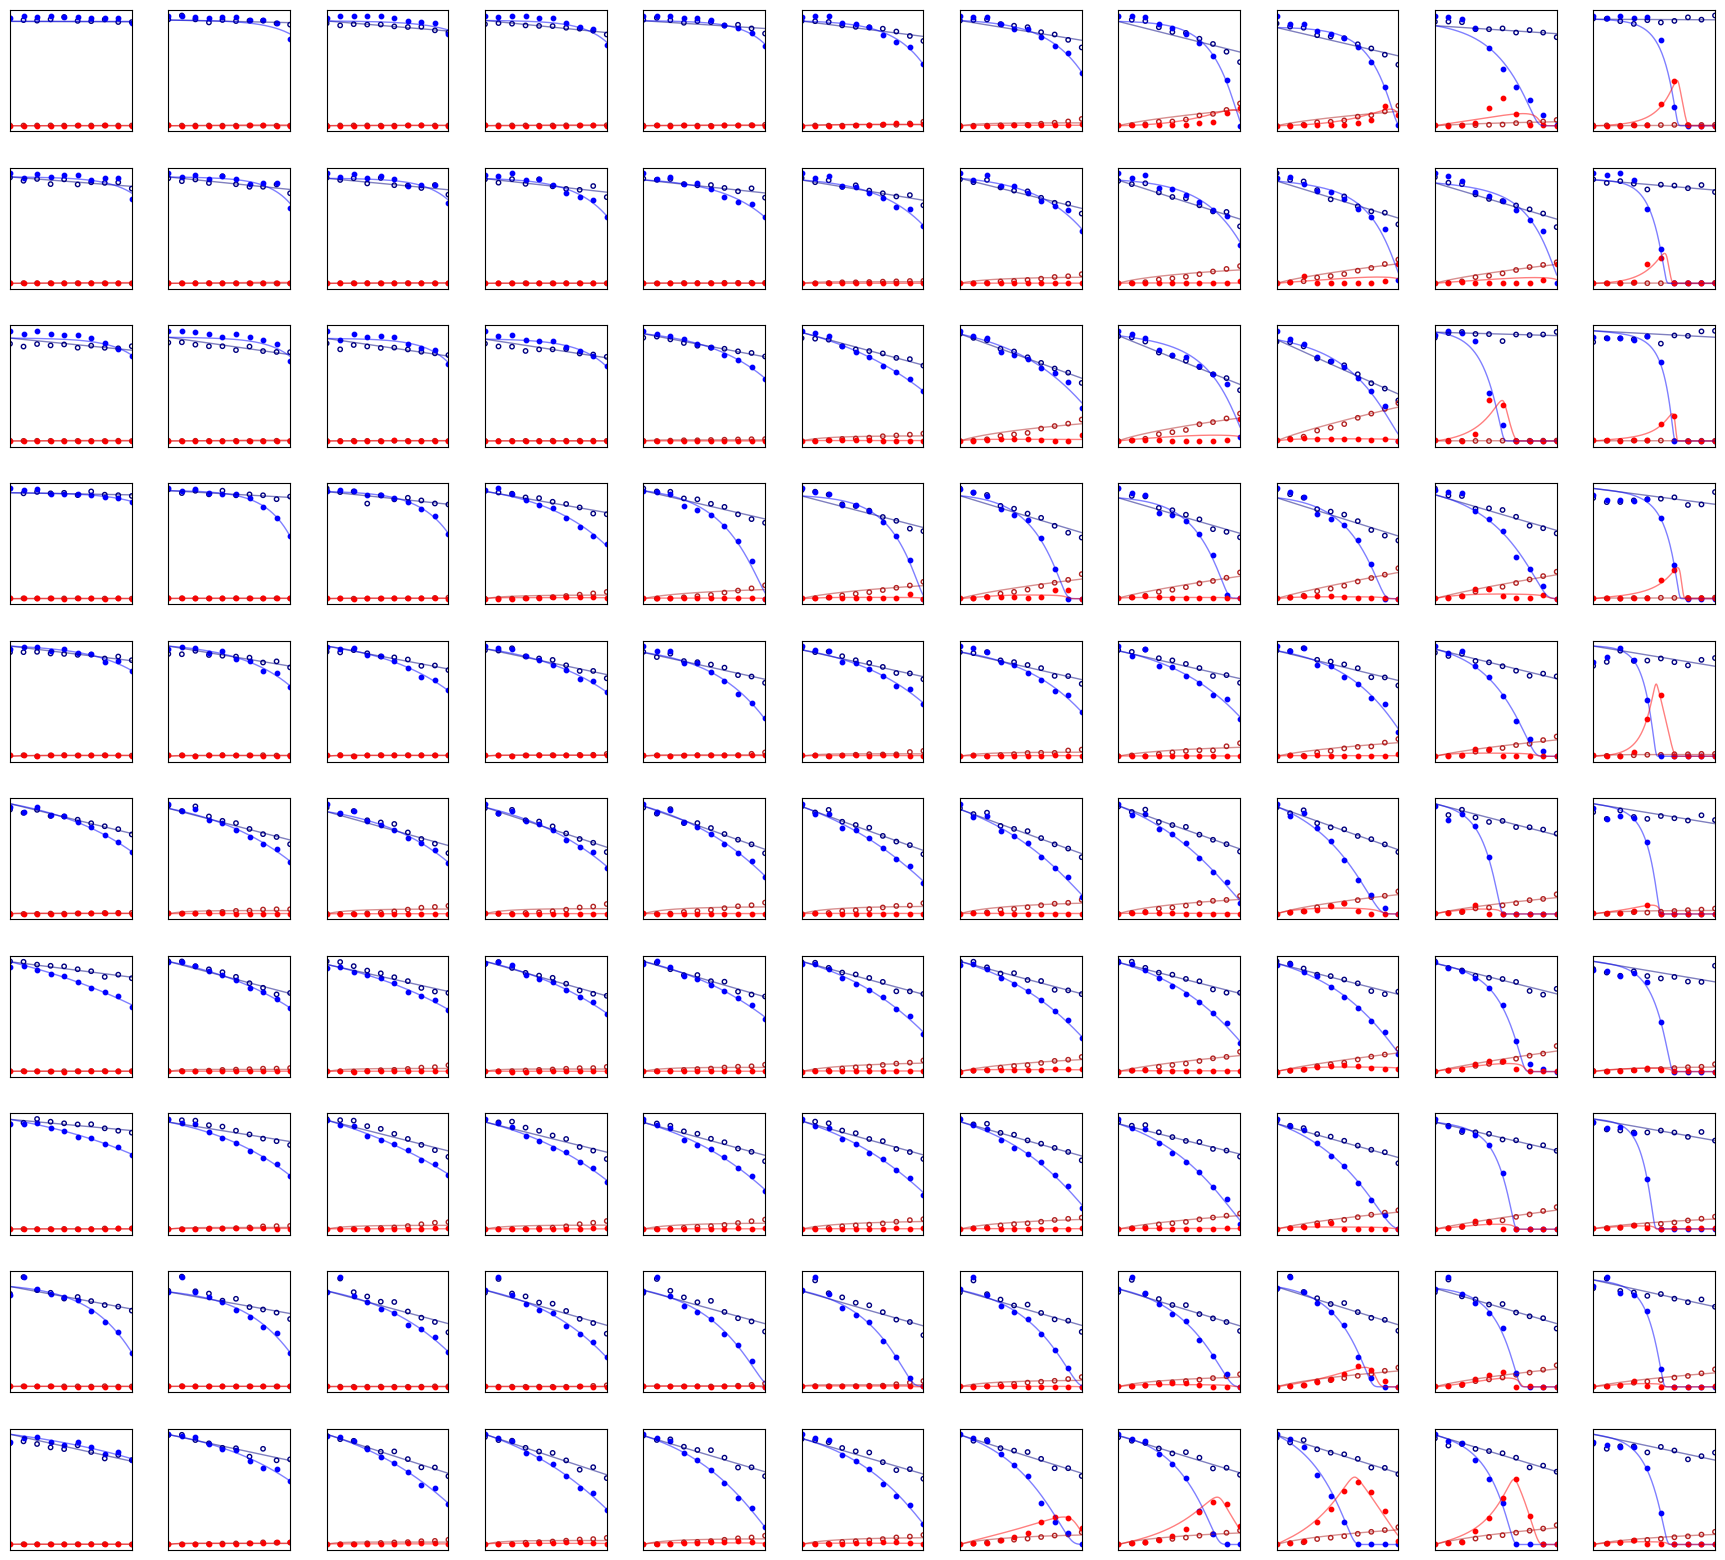

In [10]:
from mgsa.io import samples_from_soils, get_function
from scipy.optimize import curve_fit

fig, axs = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)


t_data = np.linspace(0, 19, 20)
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 
         'Soil15', 'Soil16', 'Soil17']

x_0 = 0.1
A_0 = 2
I_0 = 0
K_A = 0.1
K_I = 0.1
mu = 0
dt = 0.05
T = 9
N = int(T/dt)

param_values = np.zeros((10,11,6))

for native in range(10): 
    for pert in range(11):  

        sample = samples_from_soils(soils[9 - native])[pert]
        
        function = get_function(sample, drug = 'CHL')
        A_data_drug = np.zeros(10)
        I_data_drug = np.zeros(10)
        for i in range(3):
            A_data_drug += function[i]
            I_data_drug += function[i + 3]
        A_data_drug = A_data_drug/3
        I_data_drug = I_data_drug/3
        y_data_drug = np.concatenate([A_data_drug, I_data_drug])
        
        function = get_function(sample)
        A_data = np.zeros(10)
        I_data = np.zeros(10)
        for i in range(3):
            A_data += function[i]
            I_data += function[i + 3]
        A_data = A_data/3
        I_data = I_data/3
        y_data = np.concatenate([A_data, I_data])
        
        def model_drug(t, r_A, r_I):
            indices = np.linspace(0, int(9/dt-1), 10).astype(int)
            y0 = np.array([x_0, A_0, I_0])
            params = [0, 0, r_A, r_I, K_A, K_I, mu]
            _, A, I = simulate(RHS_v3, y0, params, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        
        initial_guess = [1.0, 1.0]
        bounds = ([0.01, 0.01,], [10, 10])
        
        popt, pcov = curve_fit(model_drug, t_data, y_data_drug, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=100000)
        
        param_values[native, pert][0] = popt[0]
        param_values[native, pert][1] = popt[1]

        y0 = np.array([x_0, A_0, I_0])
        params = [0, 0, popt[0], popt[1],  K_A, K_I, mu]
        x, A, I = simulate(RHS_v3, y0, params, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='navy', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='firebrick', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data_drug, color='navy', s=10, facecolors = 'none')
        ax.scatter(t_scatter, I_data_drug, color='firebrick', s=10, facecolors = 'none')
        
        def model(t, gamma_A, gamma_I, r_A, r_I):
            indices = np.linspace(0, int(9/dt-1), 10).astype(int)
            y0 = np.array([x_0, A_0, I_0])
            params = [gamma_A, gamma_I, r_A, r_I, K_A, K_I, mu]
            _, A, I = simulate(RHS_v3, y0, params, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        initial_guess = [1.0, 1.0, 0.1, 0.1]
        bounds = ([0.001, 0.001, 0.001, 0.001], [10, 10, 10, 10])
        
        popt, pcov = curve_fit(model, t_data, y_data, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=100000)
        
        param_values[native, pert][2] = popt[0]
        param_values[native, pert][3] = popt[1]
        param_values[native, pert][4] = popt[2]
        param_values[native, pert][5] = popt[3]
        
        y0 = np.array([x_0, A_0, I_0])
        params = [popt[0], popt[1], popt[2], popt[3], K_A, K_I, mu]
        x, A, I = simulate(RHS_v3, y0, params, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='Blue', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='Red', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data, color='Blue', s=10)
        ax.scatter(t_scatter, I_data, color='Red', s=10)
        
        ax.set_xlim(0, 9)
        
        ax.set_xticks([])
        ax.set_yticks([])
        

plt.show()

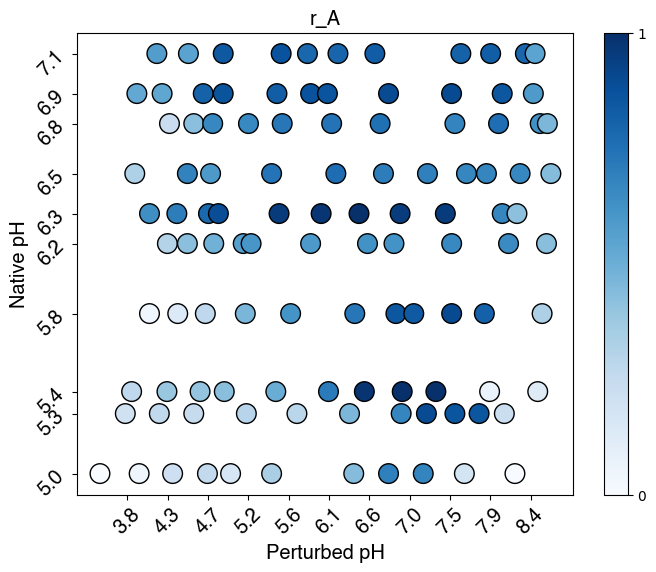

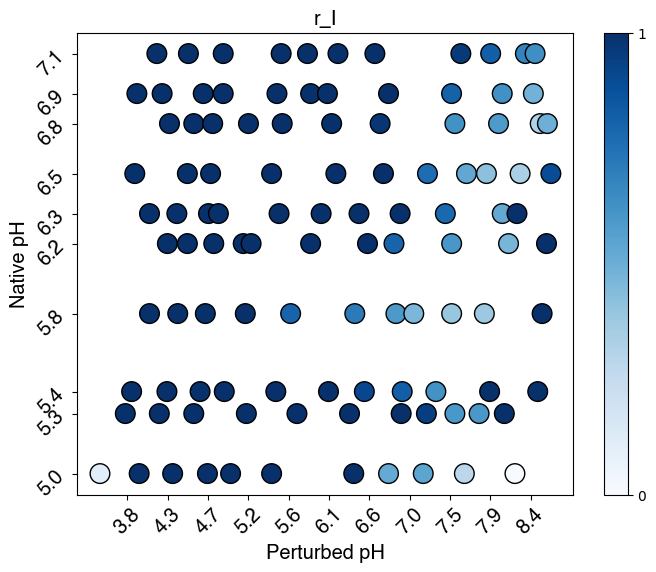

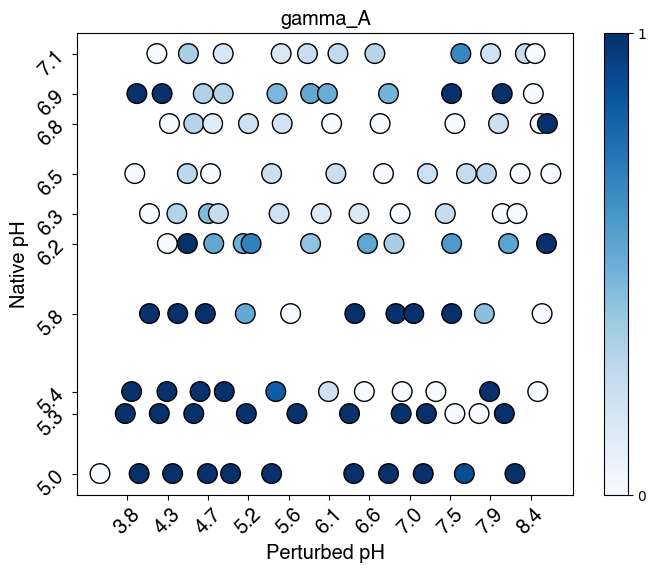

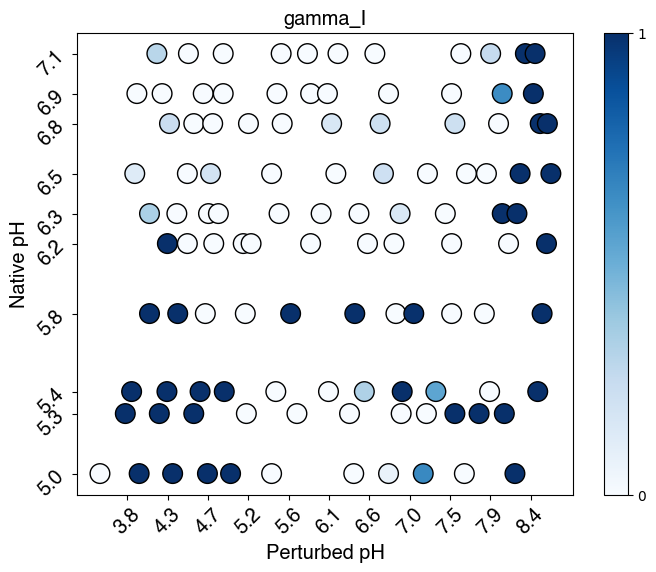

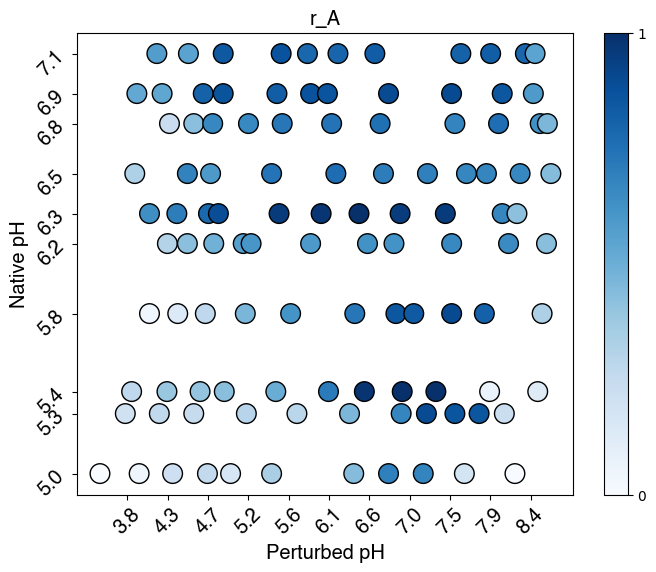

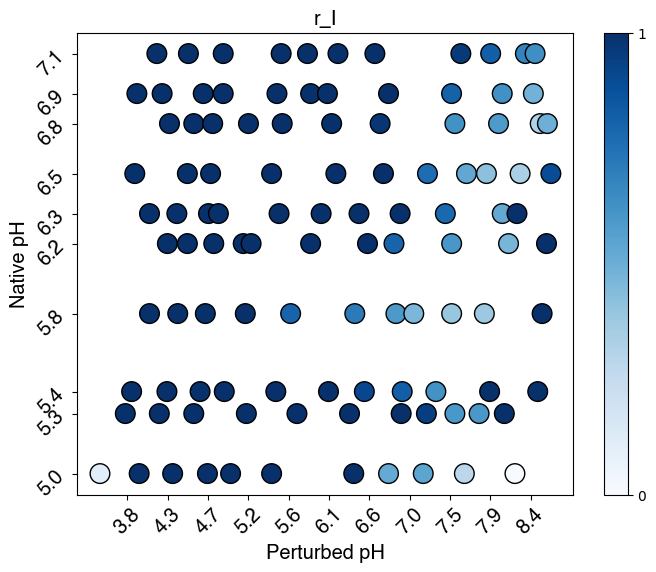

In [11]:
plot(param_values[:,:,0], 'r_A', vmax = 1)
plot(param_values[:,:,1], 'r_I', vmax = 1)
plot(param_values[:,:,2], 'gamma_A', vmin = 0, vmax = 1)
plot(param_values[:,:,3], 'gamma_I', vmin = 0, vmax = 1)
plot(param_values[:,:,0], 'r_A', vmax = 1)
plot(param_values[:,:,1], 'r_I', vmax = 1)

# A Model we expect to fail in regime III:

use rates from CHL+, then fit uptakes for CHL-. 

Why should this fail? the rates change when the nit-6 emerges...

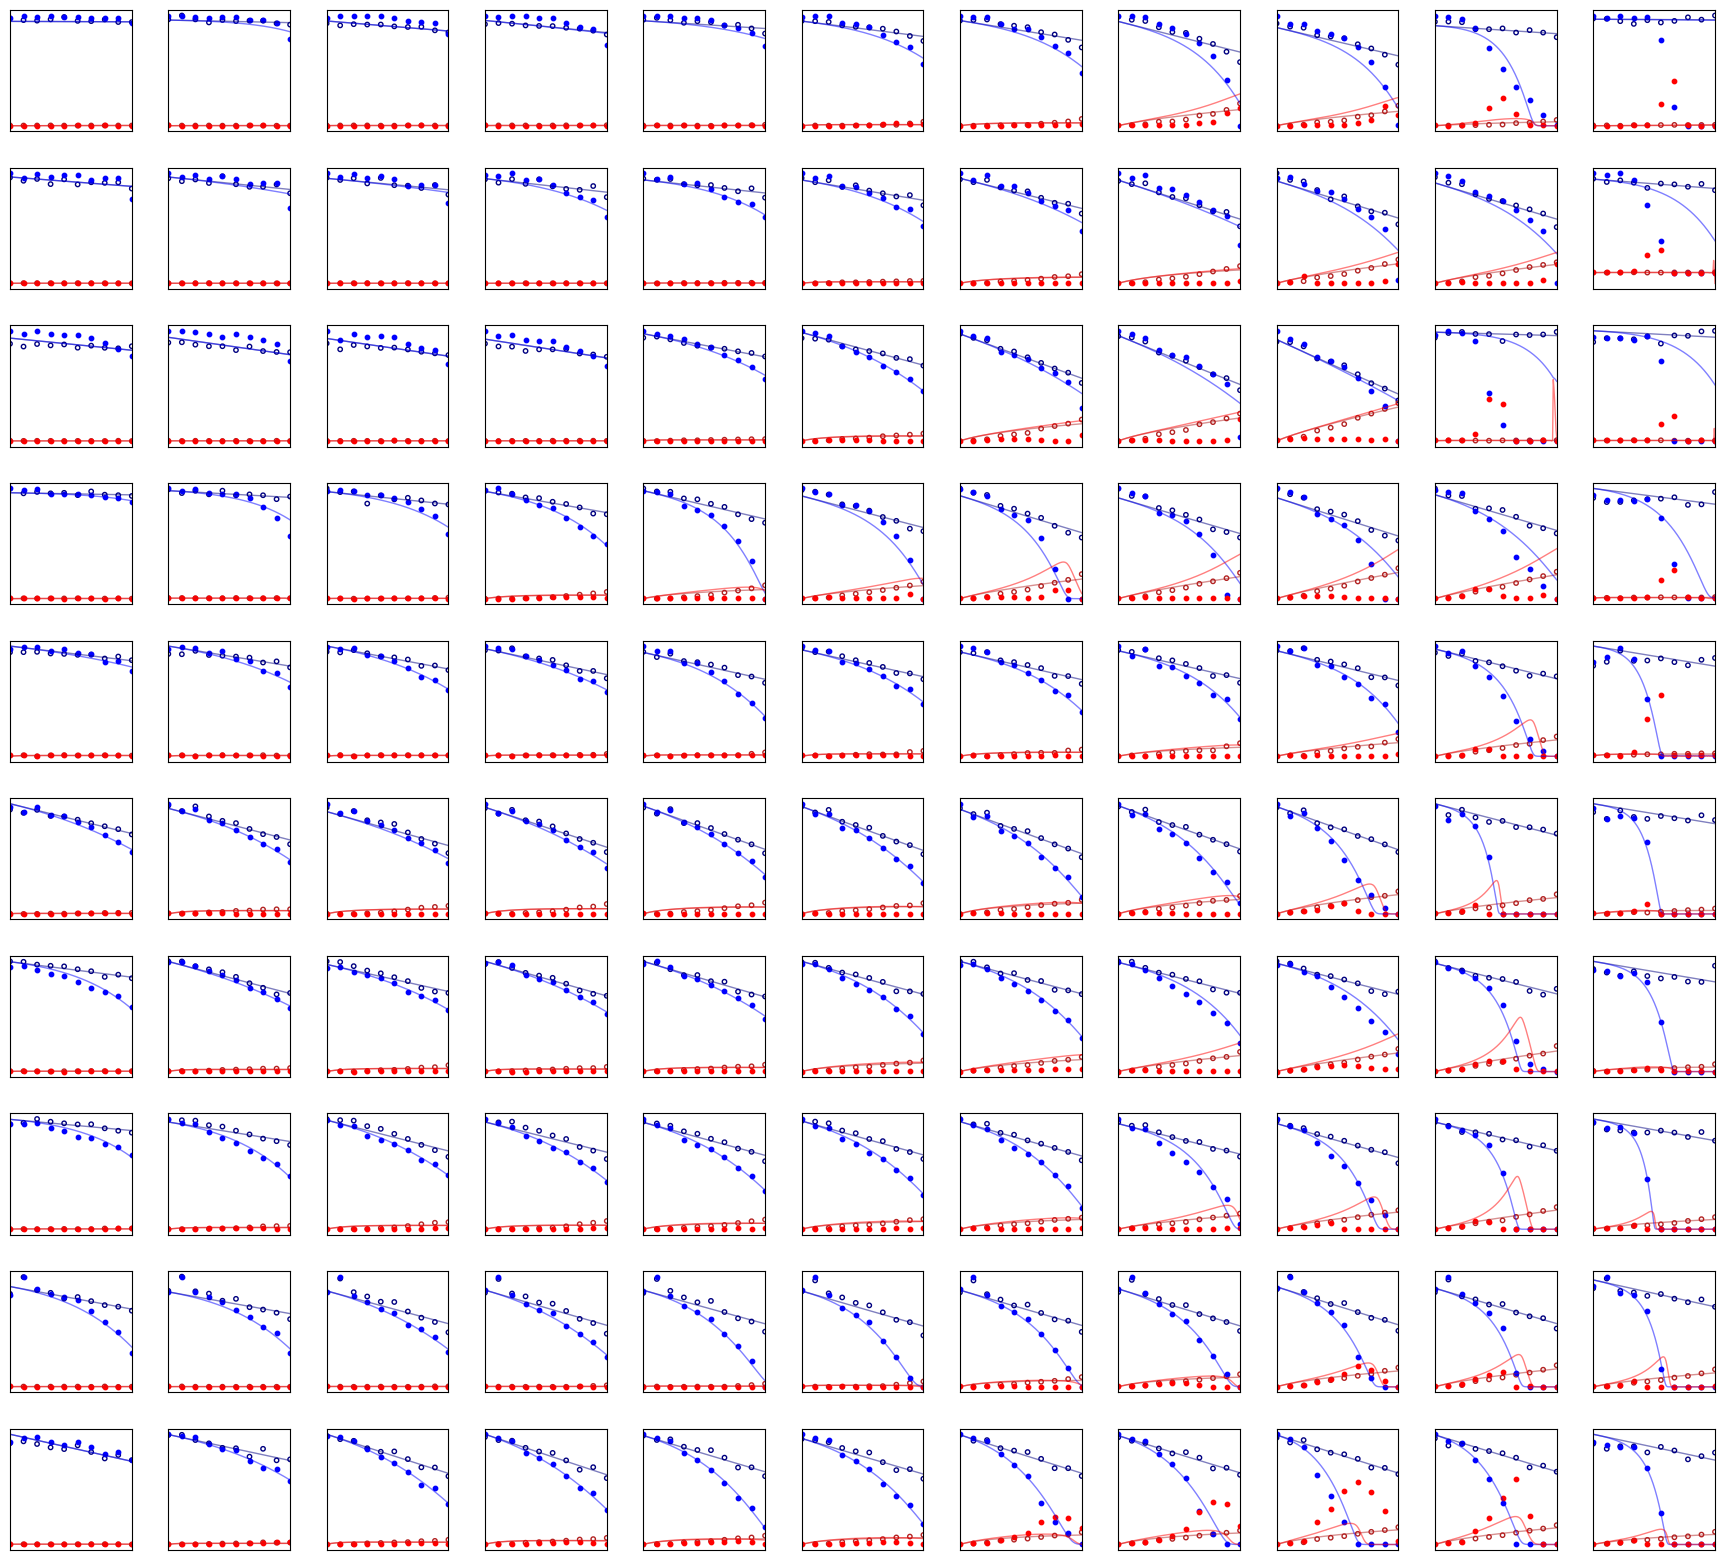

In [12]:
from mgsa.io import samples_from_soils, get_function
from scipy.optimize import curve_fit

fig, axs = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)


t_data = np.linspace(0, 19, 20)
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 
         'Soil15', 'Soil16', 'Soil17']

x_0 = 0.1
A_0 = 2
I_0 = 0
K_A = 0.1
K_I = 0.1
mu = 0
dt = 0.05
T = 9
N = int(T/dt)

param_values = np.zeros((10,11,4))

for native in range(10): 
    for pert in range(11):  

        sample = samples_from_soils(soils[9 - native])[pert]
        
        function = get_function(sample, drug = 'CHL')
        A_data_drug = np.zeros(10)
        I_data_drug = np.zeros(10)
        for i in range(3):
            A_data_drug += function[i]
            I_data_drug += function[i + 3]
        A_data_drug = A_data_drug/3
        I_data_drug = I_data_drug/3
        y_data_drug = np.concatenate([A_data_drug, I_data_drug])
        
        function = get_function(sample)
        A_data = np.zeros(10)
        I_data = np.zeros(10)
        for i in range(3):
            A_data += function[i]
            I_data += function[i + 3]
        A_data = A_data/3
        I_data = I_data/3
        y_data = np.concatenate([A_data, I_data])
        
        def model_drug(t, r_A, r_I):
            indices = np.linspace(0, int(9/dt-1), 10).astype(int)
            y0 = np.array([x_0, A_0, I_0])
            params = [0, 0, r_A, r_I, K_A, K_I, mu]
            _, A, I = simulate(RHS_v3, y0, params, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        
        initial_guess = [1.0, 1.0]
        bounds = ([0.01, 0.01,], [10, 10])
        
        popt, pcov = curve_fit(model_drug, t_data, y_data_drug, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=10000)
        
        param_values[native, pert][0] = popt[0]
        param_values[native, pert][1] = popt[1]
        rA_drug = popt[0]
        rI_drug = popt[1]
        y0 = np.array([x_0, A_0, I_0])
        params = [0, 0, popt[0], popt[1],  K_A, K_I, mu]
        x, A, I = simulate(RHS_v3, y0, params, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='navy', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='firebrick', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data_drug, color='navy', s=10, facecolors = 'none')
        ax.scatter(t_scatter, I_data_drug, color='firebrick', s=10, facecolors = 'none')
        
        def model(t, gamma_A, gamma_I):
            indices = np.linspace(0, int(9/dt-1), 10).astype(int)
            y0 = np.array([x_0, A_0, I_0])
            params = [gamma_A, gamma_I, rA_drug, rI_drug, K_A, K_I, mu]
            _, A, I = simulate(RHS_v3, y0, params, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        initial_guess = [0.1, 0.1]
        bounds = ([0.001, 0.001], [10, 10])
        
        popt, pcov = curve_fit(model, t_data, y_data, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=100000)
        
        param_values[native, pert][2] = popt[0]
        param_values[native, pert][3] = popt[1]
        
        y0 = np.array([x_0, A_0, I_0])
        params = [popt[0], popt[1], rA_drug, rI_drug, K_A, K_I, mu]
        x, A, I = simulate(RHS_v3, y0, params, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='Blue', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='Red', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data, color='Blue', s=10)
        ax.scatter(t_scatter, I_data, color='Red', s=10)
        
        ax.set_xlim(0, 9)
        
        ax.set_xticks([])
        ax.set_yticks([])
        

plt.show()

# How do we fix the failure of the above model? 

Define a preference for nirB over nit-6, $\xi$. 

With drug data, fit $r_A$ and $\xi r_I$. 

With no drug data, fit $\xi$, $\gamma_A$, $\gamma_I$. 

Let $x_1$ be narG, $x_2$ be nirB and $x_3$ be nit-6. 

\begin{align*}
    \alpha &= \gamma_A r_A \frac{A}{K_A + A} x_1 +  \gamma_I r_I \frac{I}{K_I + I} \bigg[\xi x_2 + (1 - \xi)x_3 \bigg]\\
    \dot{x_1} &=  \alpha - \mu x_1\\
    \dot{x_2} &= \xi*\alpha - \mu x_2\\
    \dot{x_3} &= (1 - \xi) * \alpha - \mu x_3\\
    \dot{A} &= -r_A \frac{A}{K_A + A} x_1 \\
    \dot{I} &= r_A \frac{A}{K_A + A} x_1 - r_I \frac{I}{K_I + I} \bigg[\xi x_2 + (1 - \xi)x_3 \bigg]
\end{align*}

In [13]:
def RHS_v2(y, params):
    x1, x2, x3, A, I = y
    gamma_A, gamma_I, r_A, r_I, xi, K_A, K_I, mu = params

    A = max(A, 1e-10)
    I = max(I, 1e-10)
    alpha = gamma_A*r_A*A/(K_A + A)*x1 + gamma_I*r_I*I/(K_I + I)*(xi*x2 + (1 - xi)*x3)
    dx1 = alpha/2 - mu*x1
    dx2 = xi*alpha/2 - mu*x2
    dx3 = (1 - xi)*alpha/2 - mu*x3
    dA = -r_A*x1*A/(K_A + A)
    dI = r_A*x1*A/(K_A + A) - (r_I*I/(K_I + I))*(xi*x2 + (1 - xi)*x3)

    dydt = np.array([dx1, dx2, dx3, dA, dI])
    return dydt


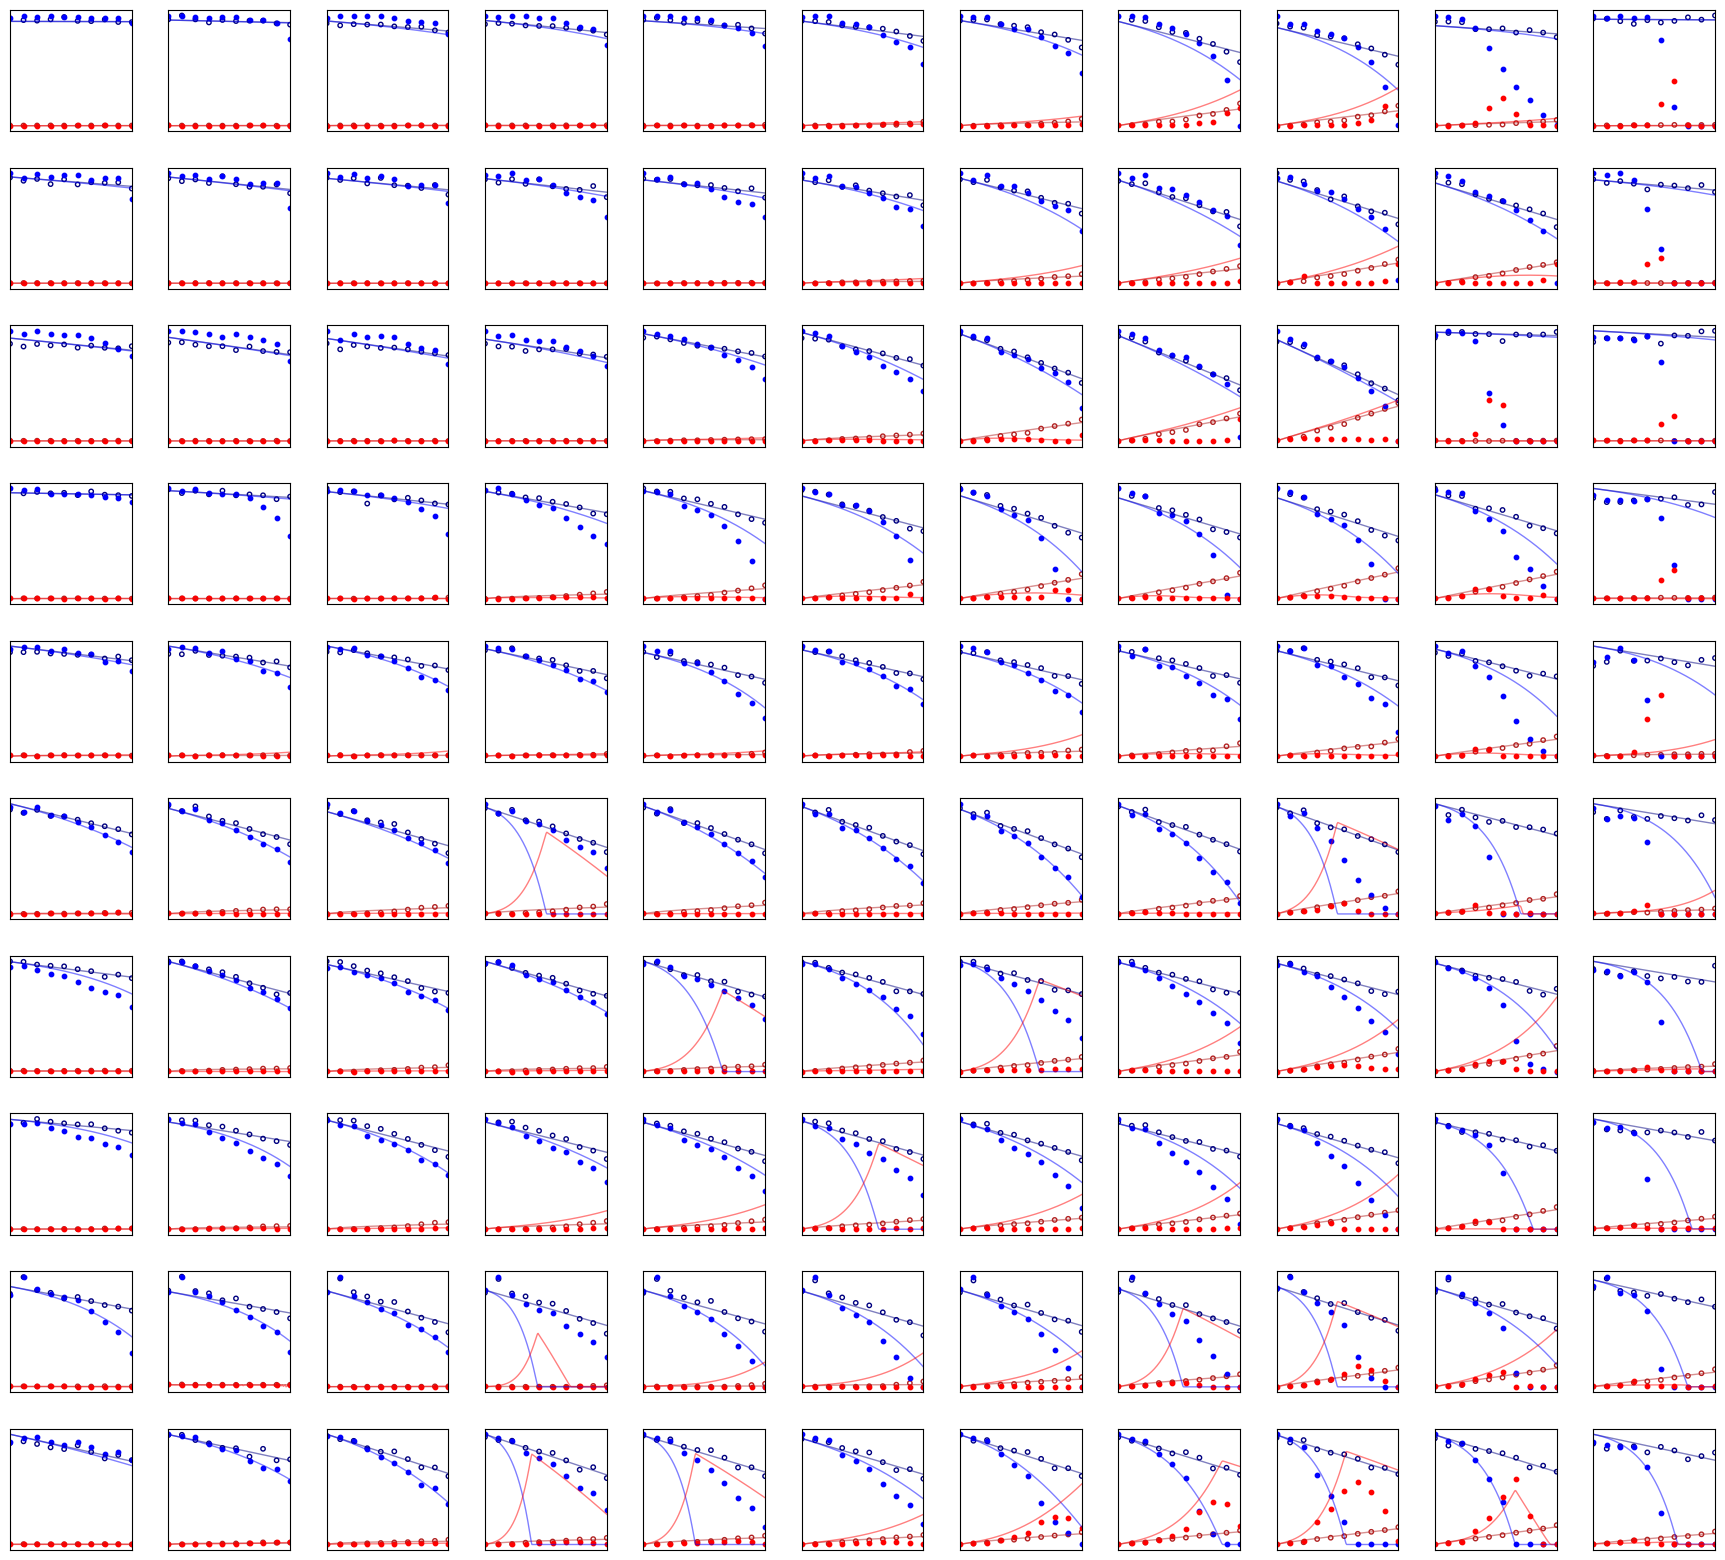

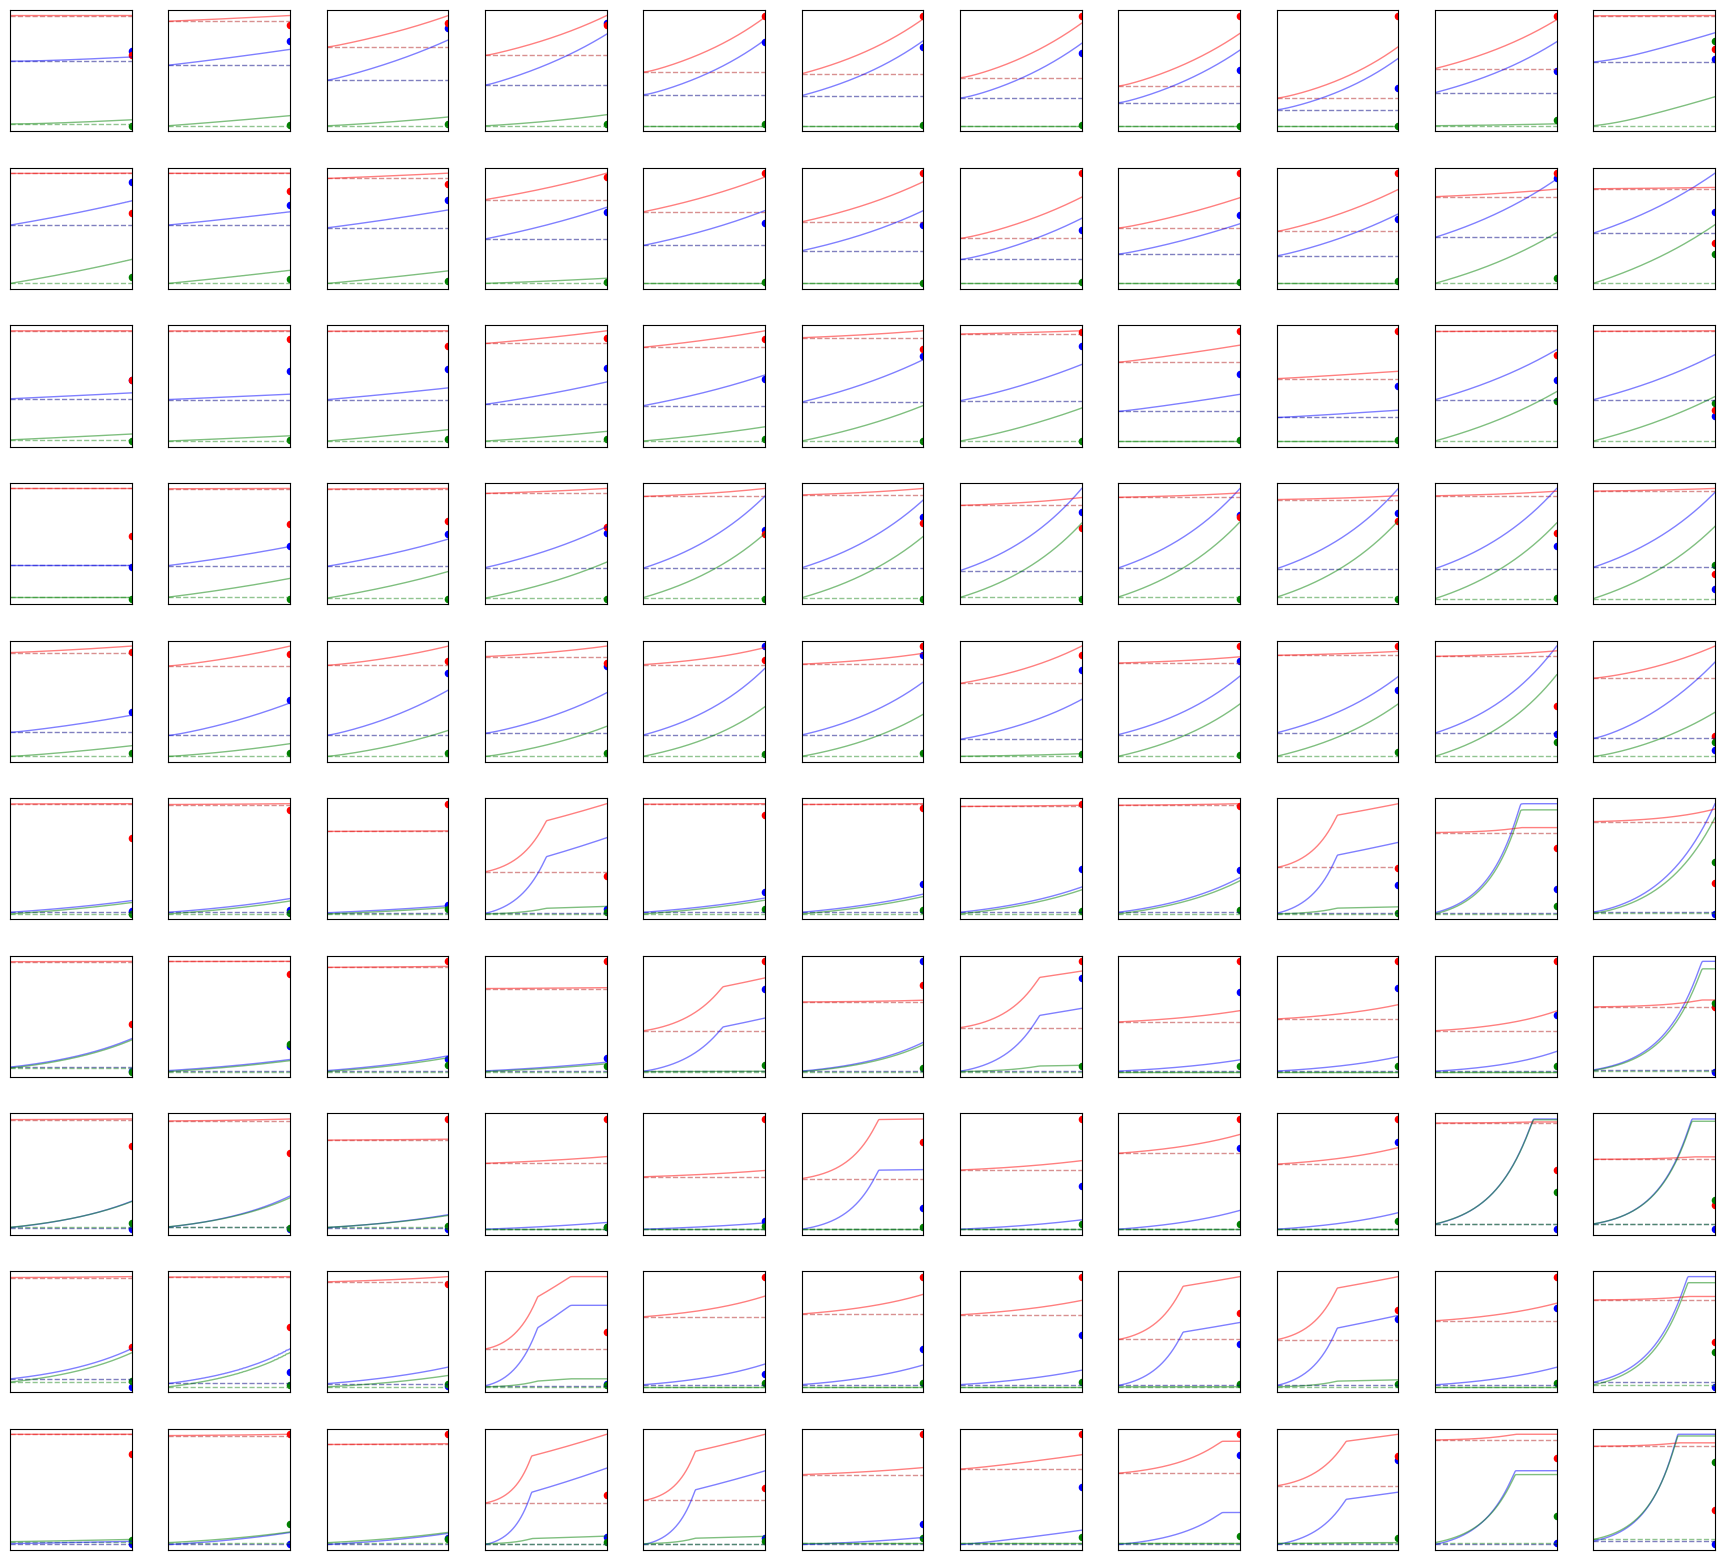

In [14]:
fig, axs = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
fig_x, axs_x = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)


t_data = np.linspace(0, 22, 23) #final 3 points will be for fitting the enzyme

sigma = np.ones(23) #specify a weighting where the biomass points 'matter more' when computing the curve fit. 
                    #we want to force it to pick parameters so that these enzyme curves do what is expected of them
                    
t_data_drug = np.linspace(0,19,20) #for the drug data, we only want to fit the Nitrate and Nitrite curves

sigma[-1] = 1
sigma[-2] = 1
sigma[-3] = 1

soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 
         'Soil15', 'Soil16', 'Soil17']

nar_t0 = pd.read_csv('../out/KO_abundances/T0data_K00370.tsv', sep = '\t', header=None).values
nar_t9_none = pd.read_csv('../out/KO_abundances/T9data_K00370_None.tsv', sep = '\t', header=None).values
nar_t9_chl = pd.read_csv('../out/KO_abundances/T9data_K00370_CHL.tsv', sep = '\t', header=None).values

nir_t0 = pd.read_csv('../out/KO_abundances/T0data_K00362.tsv', sep = '\t', header=None).values
nir_t9_none = pd.read_csv('../out/KO_abundances/T9data_K00362_None.tsv', sep = '\t', header=None).values
nir_t9_chl = pd.read_csv('../out/KO_abundances/T9data_K00362_CHL.tsv', sep = '\t', header=None).values

nit_t0 = pd.read_csv('../out/KO_abundances/T0data_K17877.tsv', sep = '\t', header=None).values
nit_t9_none = pd.read_csv('../out/KO_abundances/T9data_K17877_None.tsv', sep = '\t', header=None).values
nit_t9_chl = pd.read_csv('../out/KO_abundances/T9data_K17877_CHL.tsv', sep = '\t', header=None).values


A_0 = 2
I_0 = 0
K_A = 0.01
K_I = 0.01
dt = 0.05
T = 9
N = int(T/dt)

indices = np.linspace(0, int(9/dt-1), 10).astype(int)

param_values = np.zeros((10,11,5))

for native in range(10): 
    for pert in range(11):  
        
        scale = nir_t0[native, pert] #initial nir concentration sets the scale
        x1_0 = nar_t0[native, pert]/scale
        x2_0 = 1
        x3_0 = nit_t0[native, pert]/scale
        
        x1_f = nar_t9_none[native, pert]/scale
        x2_f = nir_t9_none[native, pert]/scale
        x3_f = nit_t9_none[native, pert]/scale
        
            
        sample = samples_from_soils(soils[9 - native])[pert]
        
        #load in data
        
        function = get_function(sample, drug = 'CHL')
        A_data_drug = np.zeros(10)
        I_data_drug = np.zeros(10)
        for i in range(3):
            A_data_drug += function[i]
            I_data_drug += function[i + 3]
        A_data_drug = A_data_drug/3
        I_data_drug = I_data_drug/3
        y_data_drug = np.concatenate([A_data_drug, I_data_drug])
        
        function = get_function(sample)
        A_data = np.zeros(10)
        I_data = np.zeros(10)
        for i in range(3):
            A_data += function[i]
            I_data += function[i + 3]
        A_data = A_data/3
        I_data = I_data/3
        y_data = np.concatenate([A_data, I_data]).tolist()  
        y_data.extend([x1_f, x2_f, x3_f])  
        y_data = np.array(y_data)
        
        def model_drug(t, r_A, r_I):
            y0 = np.array([x1_0, x2_0, x3_0, A_0, I_0])
            params = [0, 0, r_A, r_I, 1, K_A, K_I, mu]
            _, _, _, A, I = simulate(RHS_v2, y0, params, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        initial_guess = [0.1, 0.1]
        bounds = ([0.001, 0.001,], [10, 1000])
        
        popt, pcov = curve_fit(model_drug, t_data_drug, y_data_drug, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=100000)
        
        param_values[native, pert][0] = popt[0]
        #param_values[native, pert][1] = popt[1]
        rA_drug = popt[0]
        xi_rI_drug = popt[1]
        y0 = np.array([x1_0, x2_0, x3_0, A_0, I_0])
        params = [0, 0, popt[0], popt[1], 1,  K_A, K_I, mu]
        x1, x2, x3, A, I = simulate(RHS_v2, y0, params, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='navy', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='firebrick', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data_drug, color='navy', s=10, facecolors = 'none')
        ax.scatter(t_scatter, I_data_drug, color='firebrick', s=10, facecolors = 'none')
        
        ax = axs_x[native, pert]
        ax.plot(t, x1, color='navy', alpha=0.5, linewidth=1, linestyle = '--')
        ax.plot(t, x2, color='firebrick', alpha=0.5, linewidth=1, linestyle = '--')
        ax.plot(t, x3, color='forestgreen', alpha=0.5, linewidth=1, linestyle = '--')
        
        def model(t, gamma_A, gamma_I, xi):
            y0 = np.array([x1_0, x2_0, x3_0, A_0, I_0])
            params = [gamma_A, gamma_I, rA_drug, xi_rI_drug/xi, xi, K_A, K_I, mu]
            x1, x2, x3, A, I = simulate(RHS_v2, y0, params, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            
            y_out = np.concatenate([A_out, I_out]).tolist()  
            y_out.extend([x1[-1], x2[-1], x3[-1]])  
            y_out = np.array(y_out)
            return y_out
        
        initial_guess = [1, 1, 0.9]
        bounds = ([0.001, 0.001, 0.01], [20, 20, 1])
        
        popt, pcov = curve_fit(model, t_data, y_data, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=100000,
                              sigma = sigma)
        
        param_values[native, pert][2] = popt[0]
        param_values[native, pert][3] = popt[1]
        param_values[native, pert][4] = popt[2]
        
        param_values[native, pert][1] = xi_rI_drug/popt[2]
        
        y0 = np.array([x1_0, x2_0, x3_0, A_0, I_0])
        params = [popt[0], popt[1], rA_drug, xi_rI_drug/popt[2], popt[2], K_A, K_I, mu]
        x1, x2, x3, A, I = simulate(RHS_v2, y0, params, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='Blue', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='Red', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data, color='Blue', s=10)
        ax.scatter(t_scatter, I_data, color='Red', s=10)
        
        ax.set_xlim(0, 9)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax = axs_x[native, pert]
        ax.plot(t, x1, color='Blue', alpha=0.5, linewidth=1)
        ax.plot(t, x2, color='Red', alpha=0.5, linewidth=1)
        ax.plot(t, x3, color='Green', alpha = 0.5, linewidth=1)
        ax.scatter(9, x1_f, color='Blue', s=20)
        ax.scatter(9, x2_f, color='Red', s=20)
        ax.scatter(9, x3_f, color='Green', s=20)
        
        ax.set_xlim(0, 9)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        
        
        
plt.show()
        
        
        
        
        

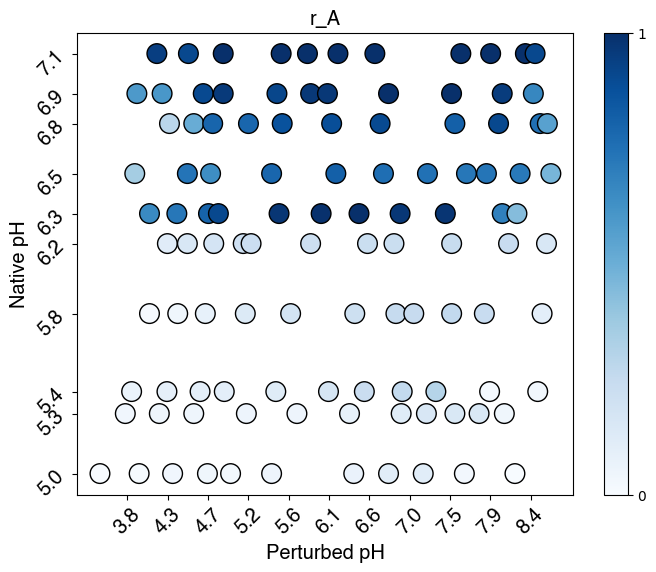

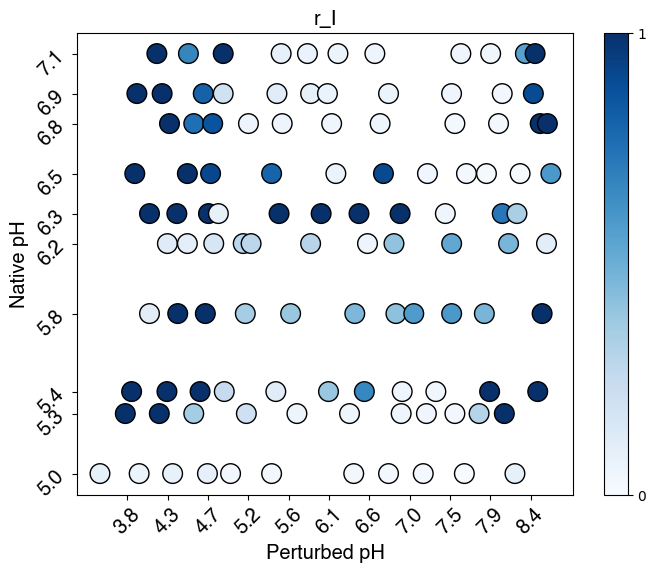

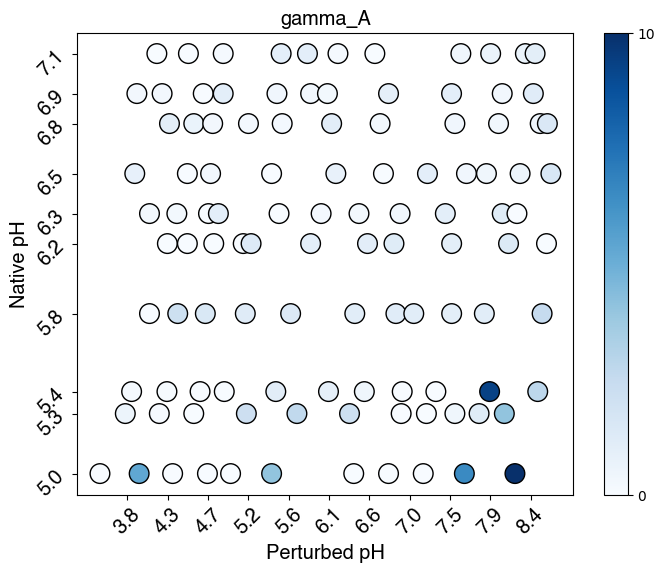

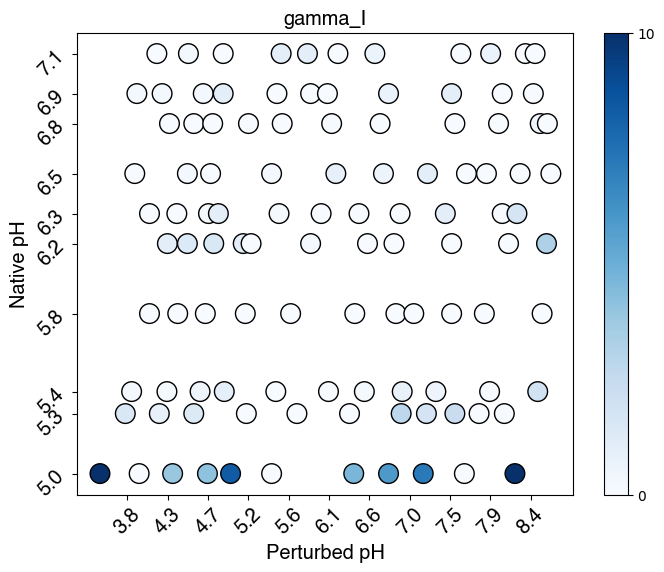

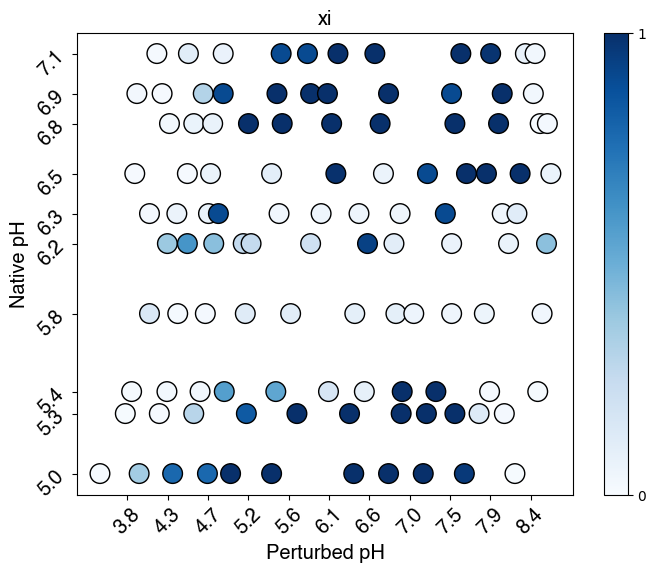

In [15]:
plot(param_values[:,:,0], 'r_A', vmax = 1)
plot(param_values[:,:,1], 'r_I', vmax = 1)
plot(param_values[:,:,2], 'gamma_A', vmin = 0, vmax = 10)
plot(param_values[:,:,3], 'gamma_I', vmin = 0, vmax = 10)
plot(param_values[:,:,4], 'xi', vmin = 0, vmax = 1)

# This isn't fitting either. Problem: the rate coefficients from the drug case cannot be extended to the drug-free case. 

Try fitting everything everywhere

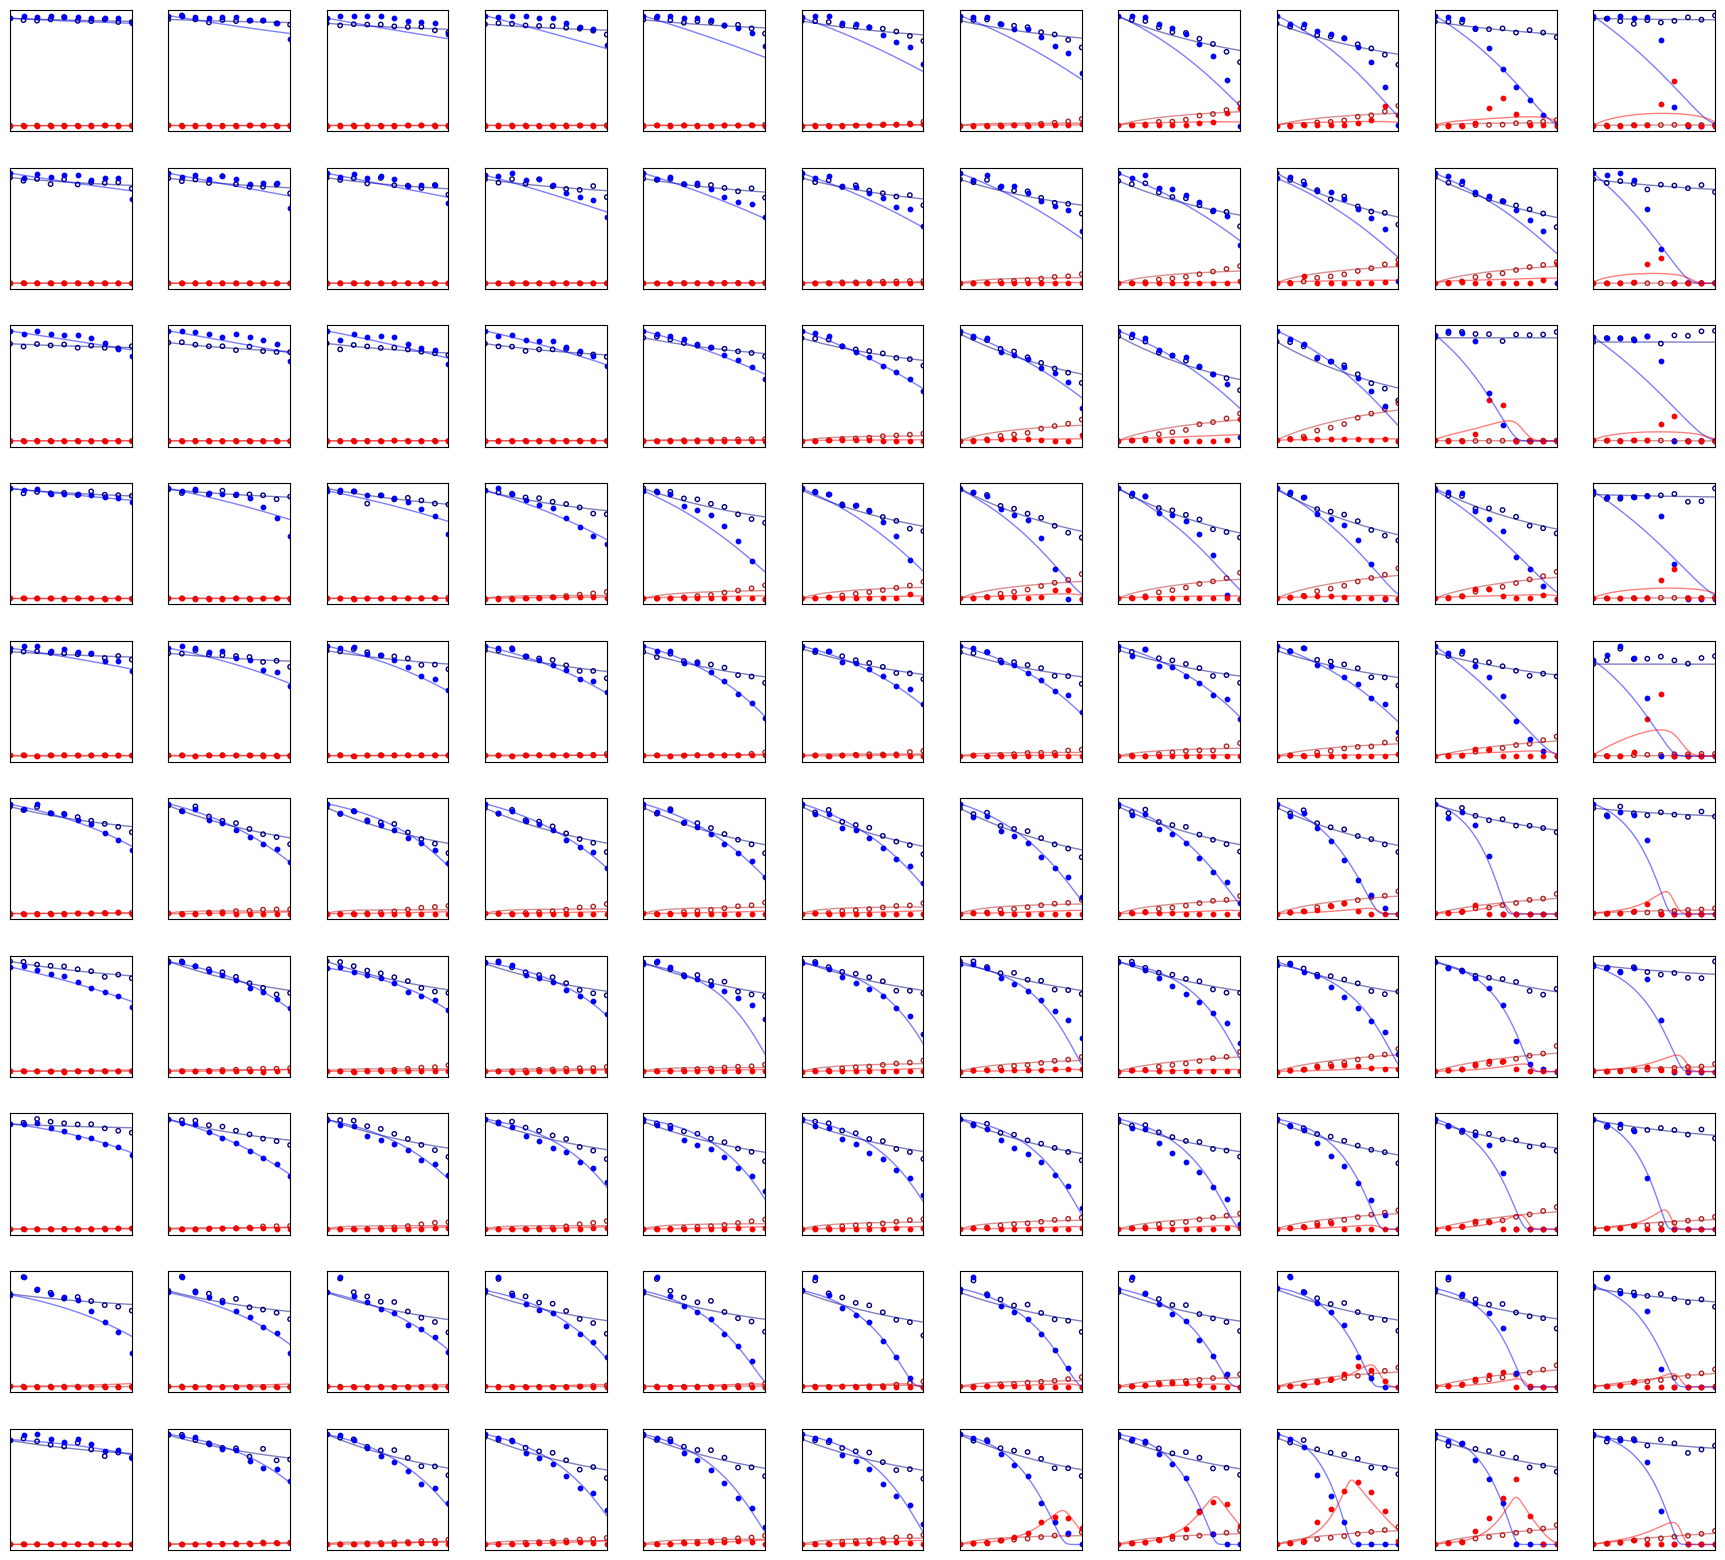

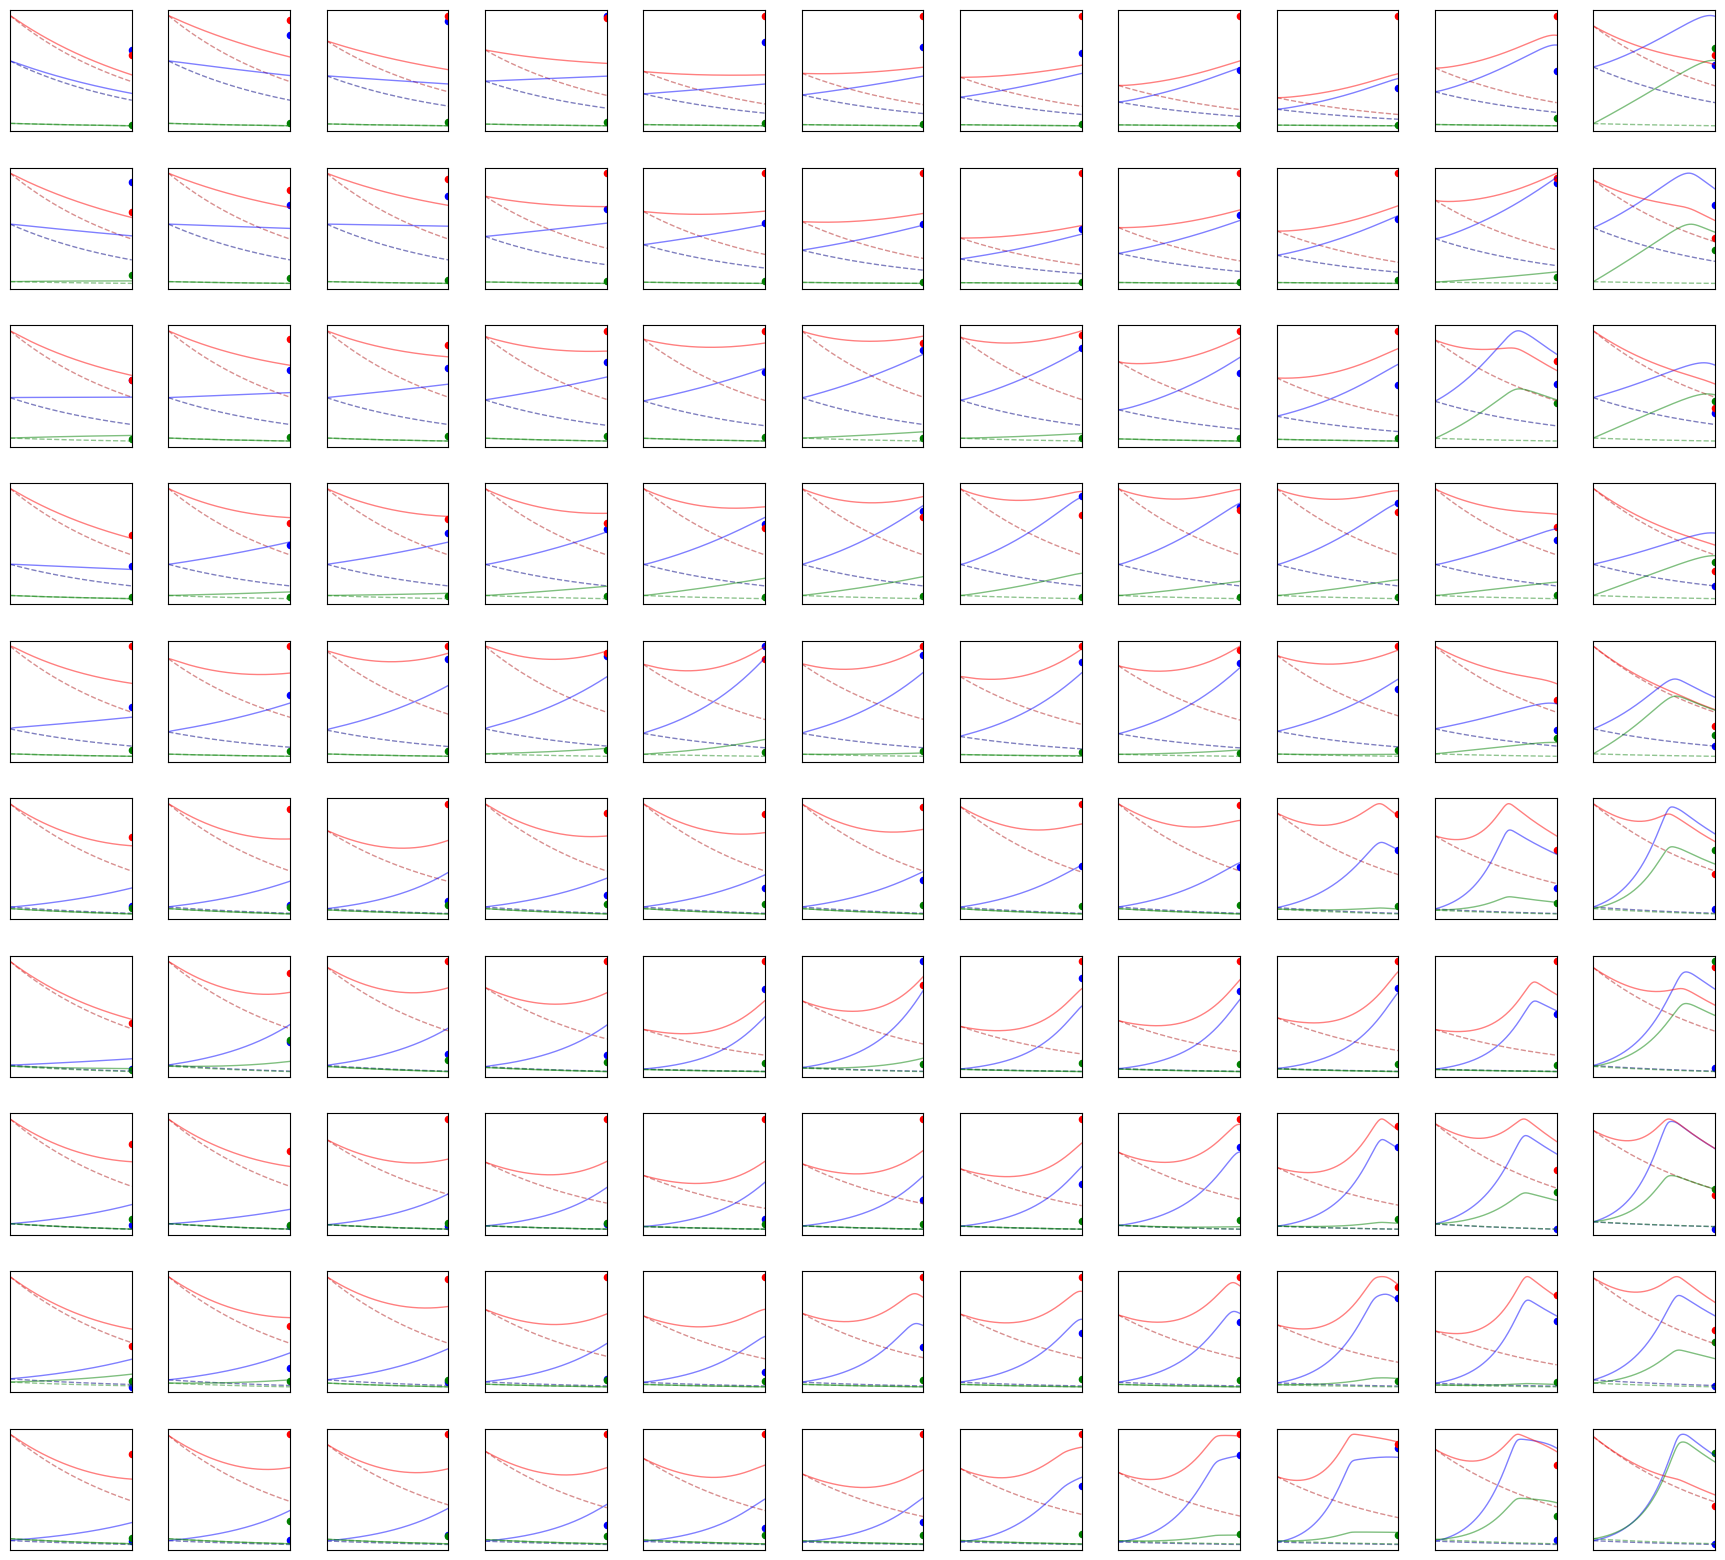

In [16]:
from mgsa.io import samples_from_soils, get_function
from scipy.optimize import curve_fit
import pandas as pd

fig, axs = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
fig_x, axs_x = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)


t_data = np.linspace(0, 22, 23) #final 3 points will be for fitting the enzyme

sigma = np.ones(23) #specify a weighting where the biomass points 'matter more' when computing the curve fit. 
                    #we want to force it to pick parameters so that these enzyme curves do what is expected of them
                    
t_data_drug = np.linspace(0,19,20) #for the drug data, we only want to fit the Nitrate and Nitrite curves

sigma[-1] = 1
sigma[-2] = 1
sigma[-3] = 1

soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 
         'Soil15', 'Soil16', 'Soil17']

nar_t0 = pd.read_csv('../out/KO_abundances/T0data_K00370.tsv', sep = '\t', header=None).values
nar_t9_none = pd.read_csv('../out/KO_abundances/T9data_K00370_None.tsv', sep = '\t', header=None).values
nar_t9_chl = pd.read_csv('../out/KO_abundances/T9data_K00370_CHL.tsv', sep = '\t', header=None).values

nir_t0 = pd.read_csv('../out/KO_abundances/T0data_K00362.tsv', sep = '\t', header=None).values
nir_t9_none = pd.read_csv('../out/KO_abundances/T9data_K00362_None.tsv', sep = '\t', header=None).values
nir_t9_chl = pd.read_csv('../out/KO_abundances/T9data_K00362_CHL.tsv', sep = '\t', header=None).values

nit_t0 = pd.read_csv('../out/KO_abundances/T0data_K17877.tsv', sep = '\t', header=None).values
nit_t9_none = pd.read_csv('../out/KO_abundances/T9data_K17877_None.tsv', sep = '\t', header=None).values
nit_t9_chl = pd.read_csv('../out/KO_abundances/T9data_K17877_CHL.tsv', sep = '\t', header=None).values


A_0 = 2
I_0 = 0
K_A = 0.1
K_I = 0.1
mu = 0.1
dt = 0.05
T = 9
N = int(T/dt)

indices = np.linspace(0, int(9/dt-1), 10).astype(int)

param_values = np.zeros((10,11,7))

for native in range(10): 
    for pert in range(11):  
        
        
        scale = nir_t0[native, pert]
        x1_0 = nar_t0[native, pert]/scale
        x2_0 = 1
        x3_0 = nit_t0[native, pert]/scale
        
        x1_f = nar_t9_none[native, pert]/scale
        x2_f = nir_t9_none[native, pert]/scale
        x3_f = nit_t9_none[native, pert]/scale
        
        
            
        sample = samples_from_soils(soils[9 - native])[pert]
        
        #load in data
        
        function = get_function(sample, drug = 'CHL')
        A_data_drug = np.zeros(10)
        I_data_drug = np.zeros(10)
        for i in range(3):
            A_data_drug += function[i]
            I_data_drug += function[i + 3]
        A_data_drug = A_data_drug/3
        I_data_drug = I_data_drug/3
        y_data_drug = np.concatenate([A_data_drug, I_data_drug])
        
        function = get_function(sample)
        A_data = np.zeros(10)
        I_data = np.zeros(10)
        for i in range(3):
            A_data += function[i]
            I_data += function[i + 3]
        A_data = A_data/3
        I_data = I_data/3
        y_data = np.concatenate([A_data, I_data]).tolist()  
        y_data.extend([x1_f, x2_f, x3_f])  
        y_data = np.array(y_data)
        
        #fit drug model
        
        A_0 = A_data_drug[0]
        I_0 = I_data_drug[0]
        def model_drug(t, r_A, r_I):
            y0 = np.array([x1_0, x2_0, x3_0, A_0, I_0])
            params = [0, 0, r_A, r_I, 1, K_A, K_I, mu]
            _, _, _, A, I = simulate(RHS_v2, y0, params, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        initial_guess = [0.1, 0.1]
        bounds = ([0.001, 0.001,], [10, 10])
        
        popt, pcov = curve_fit(model_drug, t_data_drug, y_data_drug, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=10000)
        
        param_values[native, pert][0] = popt[0]
        param_values[native, pert][1] = popt[1]

        y0 = np.array([x1_0, x2_0, x3_0, A_0, I_0])
        params = [0, 0, popt[0], popt[1], 1,  K_A, K_I, mu]
        x1, x2, x3, A, I = simulate(RHS_v2, y0, params, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='navy', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='firebrick', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data_drug, color='navy', s=10, facecolors = 'none')
        ax.scatter(t_scatter, I_data_drug, color='firebrick', s=10, facecolors = 'none')
        
        ax = axs_x[native, pert]
        ax.plot(t, x1, color='navy', alpha=0.5, linewidth=1, linestyle = '--')
        ax.plot(t, x2, color='firebrick', alpha=0.5, linewidth=1, linestyle = '--')
        ax.plot(t, x3, color='forestgreen', alpha=0.5, linewidth=1, linestyle = '--')
        
        A_0 = A_data[0]
        I_0 = I_data[0]
        def model(t, gamma_A, gamma_I, r_A, r_I, xi):
            y0 = np.array([x1_0, x2_0, x3_0, A_0, I_0])
            params = [gamma_A, gamma_I, r_A, r_I, xi, K_A, K_I, mu]
            x1, x2, x3, A, I = simulate(RHS_v2, y0, params, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            
            y_out = np.concatenate([A_out, I_out]).tolist()  
            y_out.extend([x1[-1], x2[-1], x3[-1]])  
            y_out = np.array(y_out)
            return y_out
        
        initial_guess = [0.1, 0.1, 0.01, 0.01, 0.9]
        bounds = ([0.001, 0.001, 0.0001, 0.0001, 0.0001], [1, 1, 1, 1, 1])
        
        popt, pcov = curve_fit(model, t_data_drug, y_data, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=10000,
                              sigma = sigma)
        
        param_values[native, pert][2] = popt[0]
        param_values[native, pert][3] = popt[1]
        param_values[native, pert][4] = popt[2]
        param_values[native, pert][5] = popt[3]
        param_values[native, pert][6] = popt[4]
        
        y0 = np.array([x1_0, x2_0, x3_0, A_0, I_0])
        params = [popt[0], popt[1], popt[2], popt[3], popt[4], K_A, K_I, mu]
        x1, x2, x3, A, I = simulate(RHS_v2, y0, params, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='Blue', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='Red', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data, color='Blue', s=10)
        ax.scatter(t_scatter, I_data, color='Red', s=10)
        
        ax.set_xlim(0, 9)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax = axs_x[native, pert]
        ax.plot(t, x1, color='Blue', alpha=0.5, linewidth=1)
        ax.plot(t, x2, color='Red', alpha=0.5, linewidth=1)
        ax.plot(t, x3, color='Green', alpha = 0.5, linewidth=1)
        ax.scatter(9, x1_f, color='Blue', s=20)
        ax.scatter(9, x2_f, color='Red', s=20)
        ax.scatter(9, x3_f, color='Green', s=20)
        
        ax.set_xlim(0, 9)
        
        ax.set_xticks([])
        ax.set_yticks([])
        

plt.show()

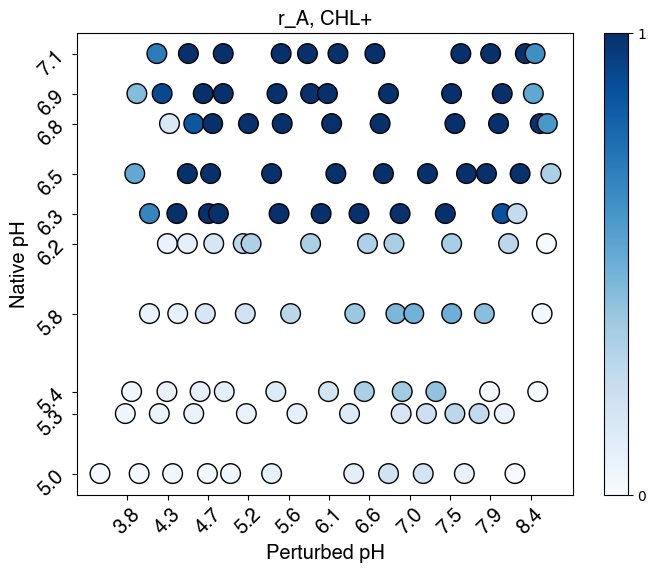

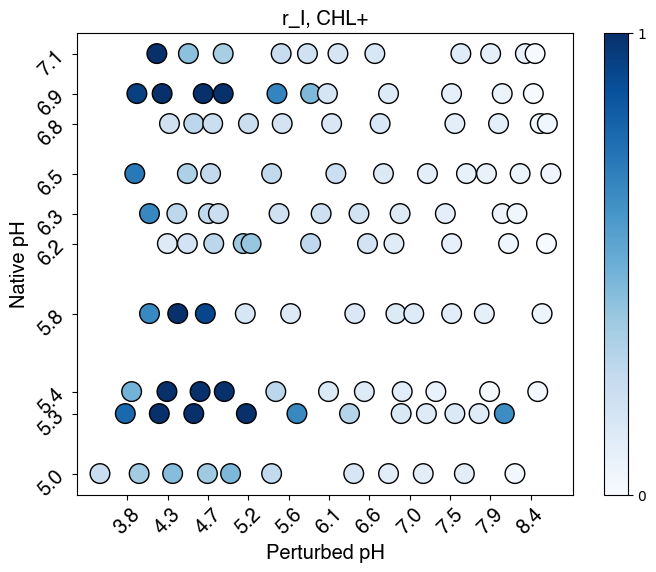

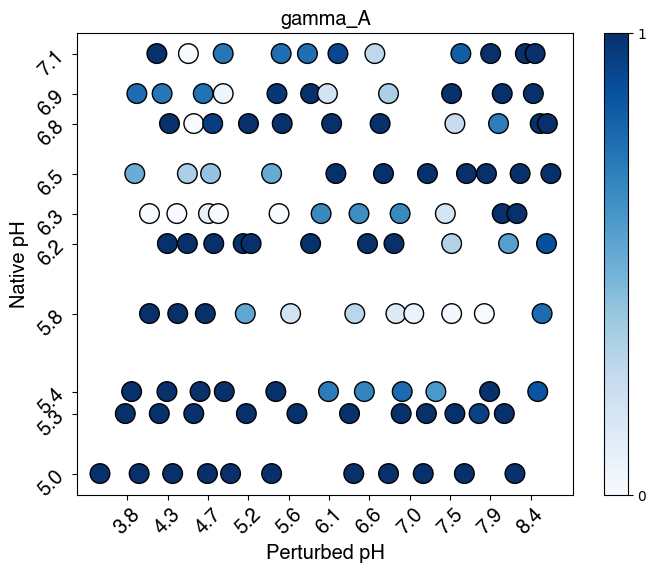

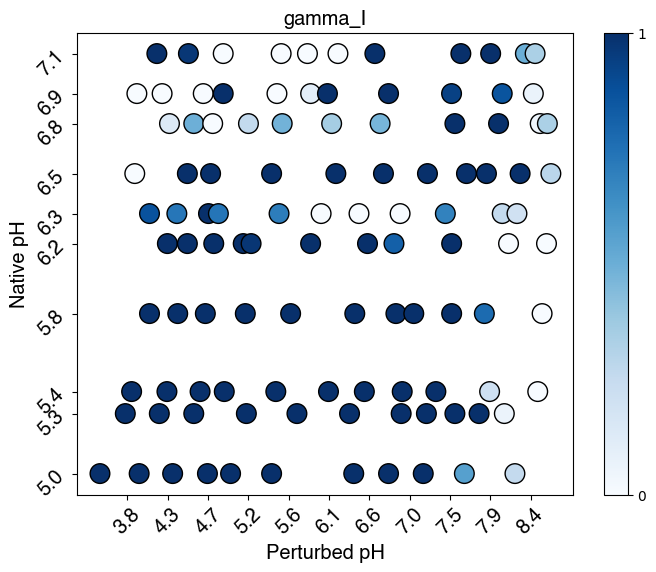

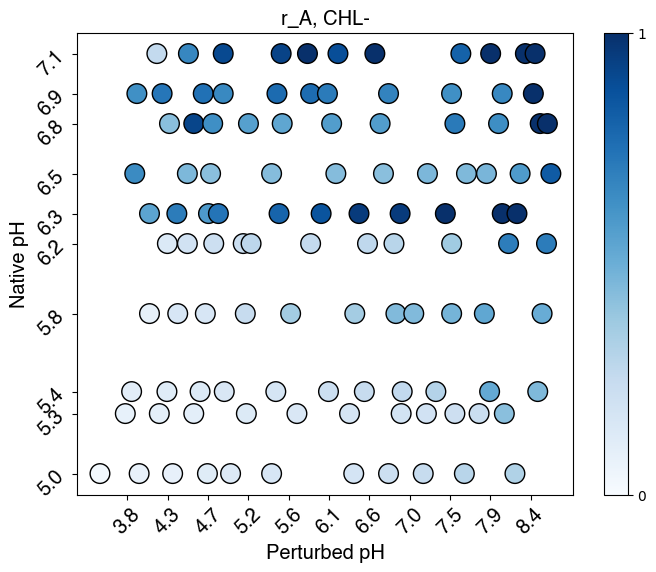

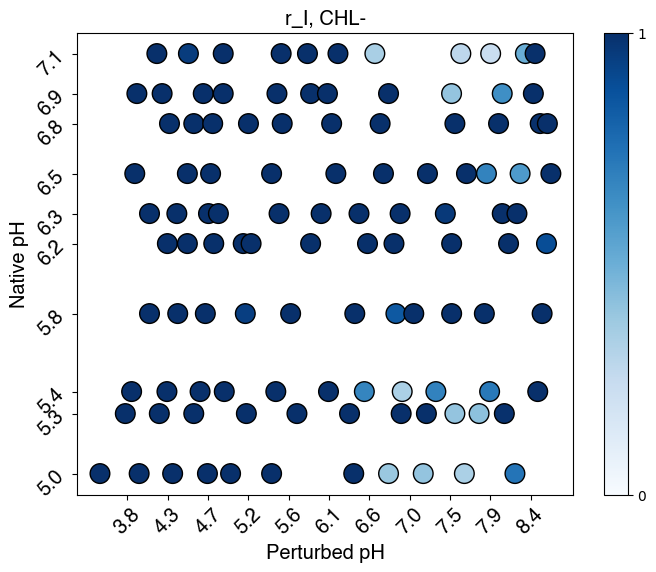

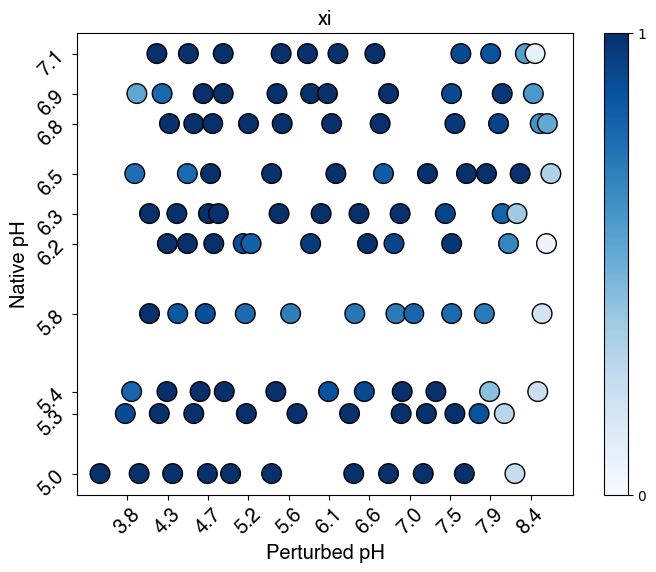

In [17]:
plot(param_values[:,:,0], 'r_A, CHL+', vmax = 1)
plot(param_values[:,:,1], 'r_I, CHL+', vmax = 1)
plot(param_values[:,:,2], 'gamma_A', vmin = 0, vmax = 1)
plot(param_values[:,:,3], 'gamma_I', vmin = 0, vmax = 1)
plot(param_values[:,:,4], 'r_A, CHL-', vmin = 0, vmax = 1)
plot(param_values[:,:,5], 'r_I, CHL-', vmin = 0, vmax = 1)

plot(param_values[:,:,6], 'xi', vmin = 0, vmax = 1)
# plot(param_values[:,:,7], 'mu', vmin = 0, vmax = 1)

Try fitting both rate constants for $x_2$ and $x_3$. Keep $\xi$ as a preference for uptake. 

$$
\begin{align*}
    \alpha &= \gamma_A r_A \frac{A}{K_A + A} x_1 +  \gamma_I \frac{I}{K_I + I} \bigg[ r_{I2} x_2 + r_{I3}x_3 \bigg]\\
    \xi_1 &= \gamma_A r_A A / \sum \xi_i, \qquad \xi_2 = \gamma_I r_{I2} I / \sum \xi_i, \qquad \xi_3 = \gamma_I r_{I3} I / \sum \xi_i\\
    \dot{x_1} &=   \xi_1\alpha - \mu x_1, \qquad \dot{x_2} =   \xi_2 \alpha - \mu x_2, \qquad \dot{x_3} = \xi_3 \alpha - \mu x_3\\
    \dot{A} &= -r_A \frac{A}{K_A + A} x_1 \\
    \dot{I} &= r_A \frac{A}{K_A + A} x_1 - r_I \frac{I}{K_I + I} \bigg[ r_{I2} x_2 + r_{I3}x_3 \bigg]
\end{align*}
$$

In [65]:
def RHS_v4(y, params):
    x1, x2, x3, A, I = y
    gamma_A, gamma_I, r_A, r_I1, r_I2, K_A, K_I, mu = params

    A = max(A, 1e-10)
    I = max(I, 1e-10)
    alpha = gamma_A*r_A*A/(K_A + A)*x1 + gamma_I*r_I*I/(K_I + I)*(r_I1*x2 + r_I2*x3)
    xi_1_temp = gamma_A*r_A*A
    xi_2_temp = gamma_I*r_I1*I
    xi_3_temp = gamma_I*r_I2*I
    xi_1 = xi_1_temp / (xi_1_temp + xi_2_temp + xi_3_temp + 1e-5)
    xi_2 = xi_2_temp / (xi_1_temp + xi_2_temp + xi_3_temp + 1e-5)
    xi_3 = xi_3_temp / (xi_1_temp + xi_2_temp + xi_3_temp + 1e-5)
    dx1 = xi_1*alpha - mu*x1
    dx2 = xi_2*alpha - mu*x2
    dx3 = xi_3*alpha/2 - mu*x3
    dA = -r_A*x1*A/(K_A + A)
    dI = r_A*x1*A/(K_A + A) - (r_I*I/(K_I + I))*(r_I1*x2 + r_I2*x3)

    dydt = np.array([dx1, dx2, dx3, dA, dI])
    return dydt


In [ ]:
from mgsa.io import samples_from_soils, get_function
from scipy.optimize import curve_fit
import pandas as pd

fig, axs = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
fig_x, axs_x = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)


t_data = np.linspace(0, 22, 23) #final 3 points will be for fitting the enzyme

sigma = np.ones(23) #specify a weighting where the biomass points 'matter more' when computing the curve fit. 
                    #we want to force it to pick parameters so that these enzyme curves do what is expected of them
                    
t_data_drug = np.linspace(0,19,20) #for the drug data, we only want to fit the Nitrate and Nitrite curves

sigma[-1] = 1
sigma[-2] = 1
sigma[-3] = 1

soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 
         'Soil15', 'Soil16', 'Soil17']

nar_t0 = pd.read_csv('../out/KO_abundances/T0data_K00370.tsv', sep = '\t', header=None).values
nar_t9_none = pd.read_csv('../out/KO_abundances/T9data_K00370_None.tsv', sep = '\t', header=None).values
nar_t9_chl = pd.read_csv('../out/KO_abundances/T9data_K00370_CHL.tsv', sep = '\t', header=None).values

nir_t0 = pd.read_csv('../out/KO_abundances/T0data_K00362.tsv', sep = '\t', header=None).values
nir_t9_none = pd.read_csv('../out/KO_abundances/T9data_K00362_None.tsv', sep = '\t', header=None).values
nir_t9_chl = pd.read_csv('../out/KO_abundances/T9data_K00362_CHL.tsv', sep = '\t', header=None).values

nit_t0 = pd.read_csv('../out/KO_abundances/T0data_K17877.tsv', sep = '\t', header=None).values
nit_t9_none = pd.read_csv('../out/KO_abundances/T9data_K17877_None.tsv', sep = '\t', header=None).values
nit_t9_chl = pd.read_csv('../out/KO_abundances/T9data_K17877_CHL.tsv', sep = '\t', header=None).values



K_A = 0.1
K_I = 0.1
mu = 0.5
dt = 0.05
T = 9
N = int(T/dt)

indices = np.linspace(0, int(9/dt-1), 10).astype(int)

param_values = np.zeros((10,11,7))

for native in range(10): 
    for pert in range(11):  
        
        
        scale = nir_t0[9 - native, pert]
        x1_0 = nar_t0[9 - native, pert]/scale
        x2_0 = 1
        x3_0 = nit_t0[9 - native, pert]/scale
        
        x1_f = nar_t9_none[9 - native, pert]/scale
        x2_f = nir_t9_none[9 - native, pert]/scale
        x3_f = nit_t9_none[9 - native, pert]/scale
        
        
            
        sample = samples_from_soils(soils[9 - native])[pert]
        
        #load in data
        
        function = get_function(sample, drug = 'CHL')
        A_data_drug = np.zeros(10)
        I_data_drug = np.zeros(10)
        for i in range(3):
            A_data_drug += function[i]
            I_data_drug += function[i + 3]
        A_data_drug = A_data_drug/3
        I_data_drug = I_data_drug/3
        y_data_drug = np.concatenate([A_data_drug, I_data_drug])
        
        function = get_function(sample)
        A_data = np.zeros(10)
        I_data = np.zeros(10)
        for i in range(3):
            A_data += function[i]
            I_data += function[i + 3]
        A_data = A_data/3
        I_data = I_data/3
        y_data = np.concatenate([A_data, I_data]).tolist()  
        y_data.extend([x1_f, x2_f, x3_f])  
        y_data = np.array(y_data)
        
        #fit drug model
        
        A_0 = A_data_drug[0]
        I_0 = I_data_drug[0]
        def model_drug(t, r_A, r_I):
            y0 = np.array([x1_0, x2_0, x3_0, A_0, I_0])
            params = [0, 0, r_A, r_I, 0, K_A, K_I, mu]
            _, _, _, A, I = simulate(RHS_v4, y0, params, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        initial_guess = [0.1, 0.1]
        bounds = ([0.001, 0.001], [10, 10])
        
        popt, pcov = curve_fit(model_drug, t_data_drug, y_data_drug, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=100000)
        
        param_values[native, pert][0] = popt[0]
        param_values[native, pert][1] = popt[1]

        y0 = np.array([x1_0, x2_0, x3_0, A_0, I_0])
        params = [0, 0, popt[0], popt[1], 0,  K_A, K_I, mu]
        x1, x2, x3, A, I = simulate(RHS_v4, y0, params, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='navy', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='firebrick', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data_drug, color='navy', s=10, facecolors = 'none')
        ax.scatter(t_scatter, I_data_drug, color='firebrick', s=10, facecolors = 'none')
        
        ax = axs_x[native, pert]
        ax.plot(t, x1, color='navy', alpha=0.5, linewidth=1, linestyle = '--')
        ax.plot(t, x2, color='firebrick', alpha=0.5, linewidth=1, linestyle = '--')
        ax.plot(t, x3, color='forestgreen', alpha=0.5, linewidth=1, linestyle = '--')
        
        A_0 = A_data[0]
        I_0 = I_data[0]
        def model(t, gamma_A, gamma_I, r_A, r_I1, r_I2):
            y0 = np.array([x1_0, x2_0, x3_0, A_0, I_0])
            params = [gamma_A, gamma_I, r_A, r_I1, r_I2, K_A, K_I, mu]
            x1, x2, x3, A, I = simulate(RHS_v4, y0, params, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            
            y_out = np.concatenate([A_out, I_out]).tolist()  
            y_out.extend([x1[-1], x2[-1], x3[-1]])  
            y_out = np.array(y_out)
            return y_out
        
        initial_guess = [2, 1, 0.01, 0.1, 0.1]
        bounds = ([0.001, 0.001, 0.0001, 0.0001, 0.0001], [10, 10, 1, 1, 1])
        
        popt, pcov = curve_fit(model, t_data, y_data, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=10000,
                              sigma = sigma)
        
        param_values[native, pert][2] = popt[0]
        param_values[native, pert][3] = popt[1]
        param_values[native, pert][4] = popt[2]
        param_values[native, pert][5] = popt[3]
        param_values[native, pert][6] = popt[4]
        
        y0 = np.array([x1_0, x2_0, x3_0, A_0, I_0])
        params = [popt[0], popt[1], popt[2], popt[3], popt[4], K_A, K_I, mu]
        x1, x2, x3, A, I = simulate(RHS_v4, y0, params, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='Blue', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='Red', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data, color='Blue', s=10)
        ax.scatter(t_scatter, I_data, color='Red', s=10)
        
        ax.set_xlim(0, 9)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax = axs_x[native, pert]
        ax.plot(t, x1, color='Blue', alpha=0.5, linewidth=1)
        ax.plot(t, x2, color='Red', alpha=0.5, linewidth=1)
        ax.plot(t, x3, color='Green', alpha = 0.5, linewidth=1)
        ax.scatter(9, x1_f, color='Blue', s=20)
        ax.scatter(9, x2_f, color='Red', s=20)
        ax.scatter(9, x3_f, color='Green', s=20)
        
        ax.set_xlim(0, 9)
        
        ax.set_xticks([])
        ax.set_yticks([])
        

plt.show()

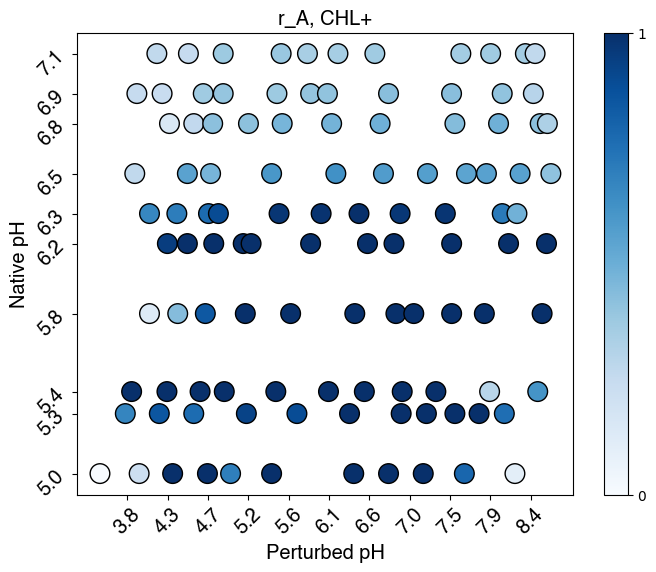

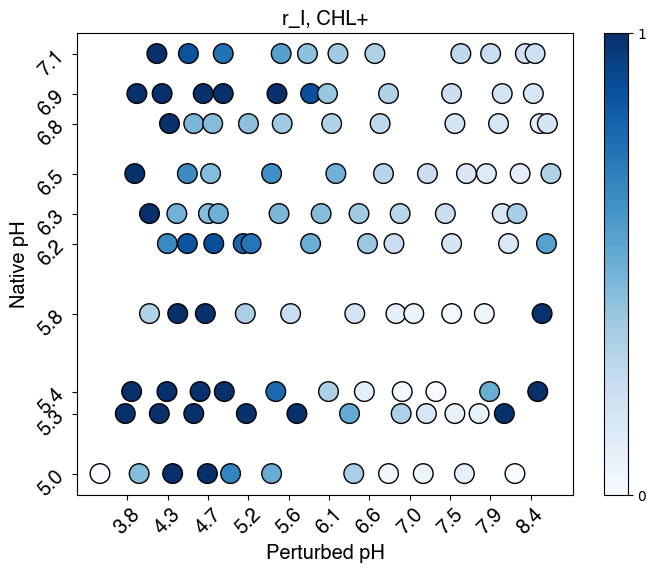

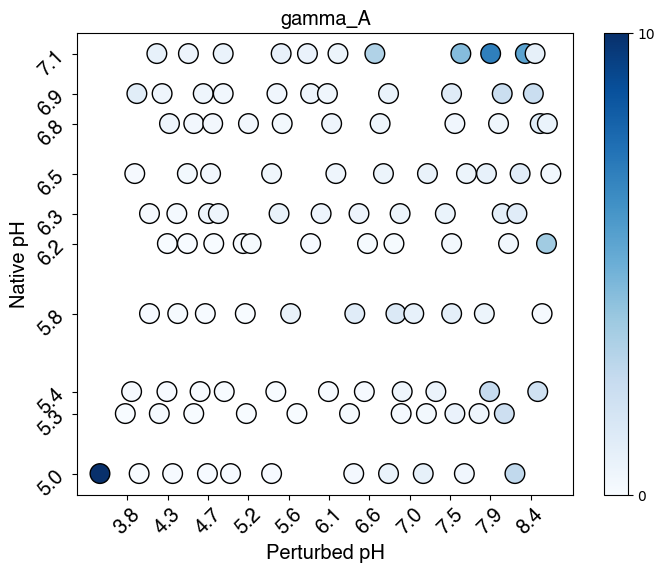

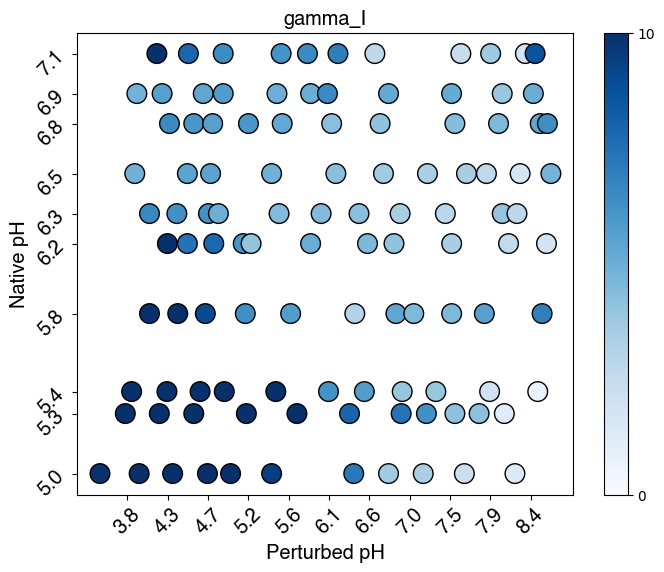

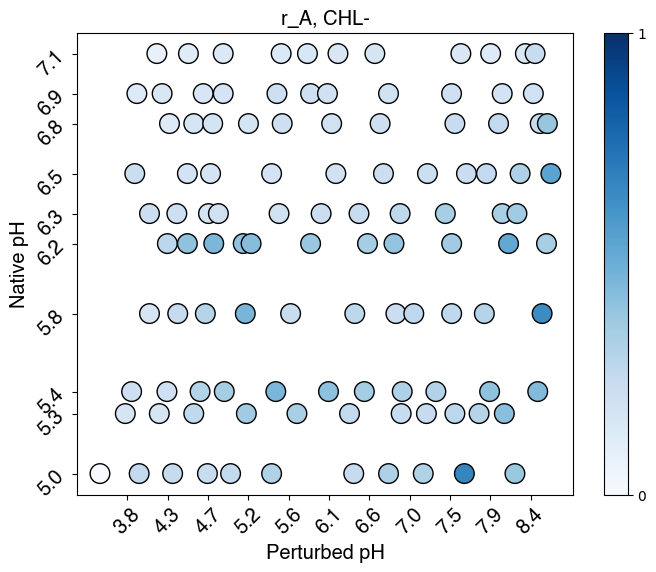

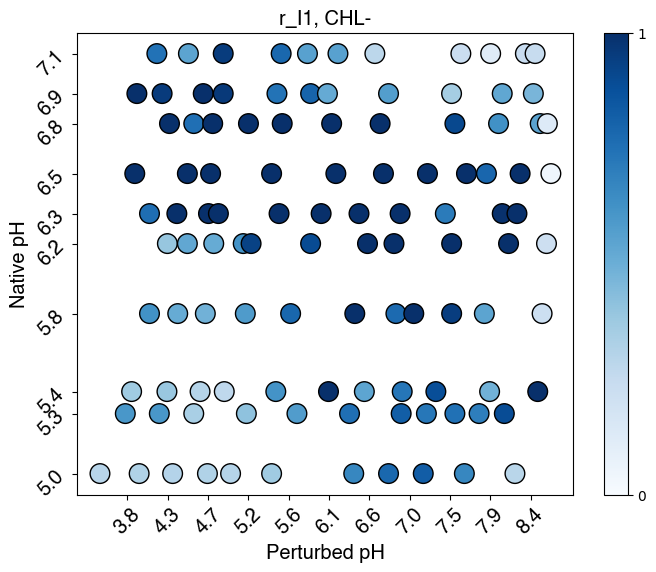

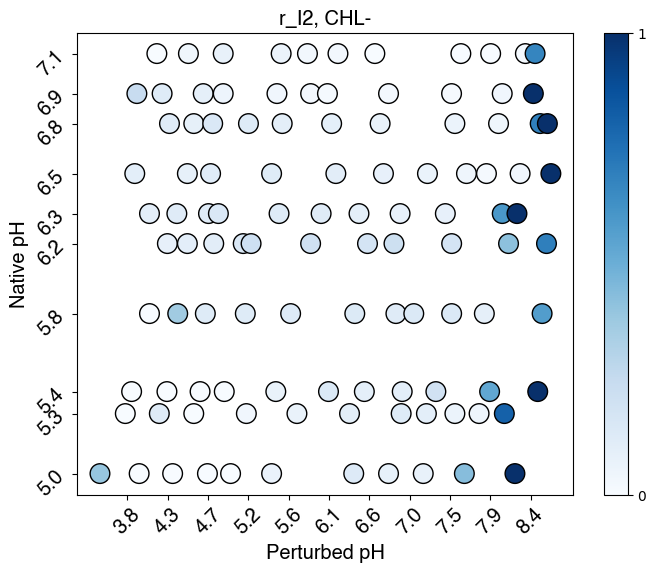

In [110]:
plot(param_values[:,:,0], 'r_A, CHL+', vmax = 1)
plot(param_values[:,:,1], 'r_I, CHL+', vmax = 1)
plot(param_values[:,:,2], 'gamma_A', vmin = 0, vmax = 10)
plot(param_values[:,:,3], 'gamma_I', vmin = 0, vmax = 10)
plot(param_values[:,:,4], 'r_A, CHL-', vmin = 0, vmax = 1)
plot(param_values[:,:,5], 'r_I1, CHL-', vmin = 0, vmax = 1)
plot(param_values[:,:,6], 'r_I2, CHL-', vmin = 0, vmax = 1)
